In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 5
2023-07-29 23:51:32.025291


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-14.3435)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(4.5727)
penalty_target_min tensor(-11.7090) penalty_target_max tensor(4.5254)
train_loss:  -8.921233970642088
valid_loss:  -8.2177935546875
h_min_tilde -11.708967 ell_tilde -8.780545887451172 kappa_tilde 0.0005843636860854795


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.624024868011475

 2 3.357060432434082

 3 3.7245266437530518

 4 3.386898994445801

 5 3.6966192722320557

 6 3.393439769744873

 7 3.3189876079559326

 8 3.298410654067993

 9 3.9934284687042236

 10 3.1121504306793213

 11 3.2013192176818848

 12 3.2715578079223633

 13 3.43963623046875

 14 3.3430120944976807

 15 3.477728843688965

 16 3.528486967086792

 17 3.1905198097229004

 18 3.219306468963623

 19 3.2344515323638916

 20 3.3743131160736084

 21 3.3879334926605225

 22 3.7676918506622314

 23 7.144683599472046

 24 6.936089277267456

 25 6.815500020980835

 26 6.978898763656616

 27 6.731614589691162

 28 6.113821506500244

 29 4.060940265655518

 30 4.488236665725708

 31 7.409392833709717

 32 7.391855478286743

 33 3.575702428817749

 34 6.456417560577393

 35 7.200070381164551

 36 4.169871807098389

 37 3.63386607170105

 38 3.5558736324310303

 39 4.250091314315796

 40 3.50144624710083

 41 3.4806132316589355

 42 3.315638780593872

 43 3.5490496158599854

 44 3.

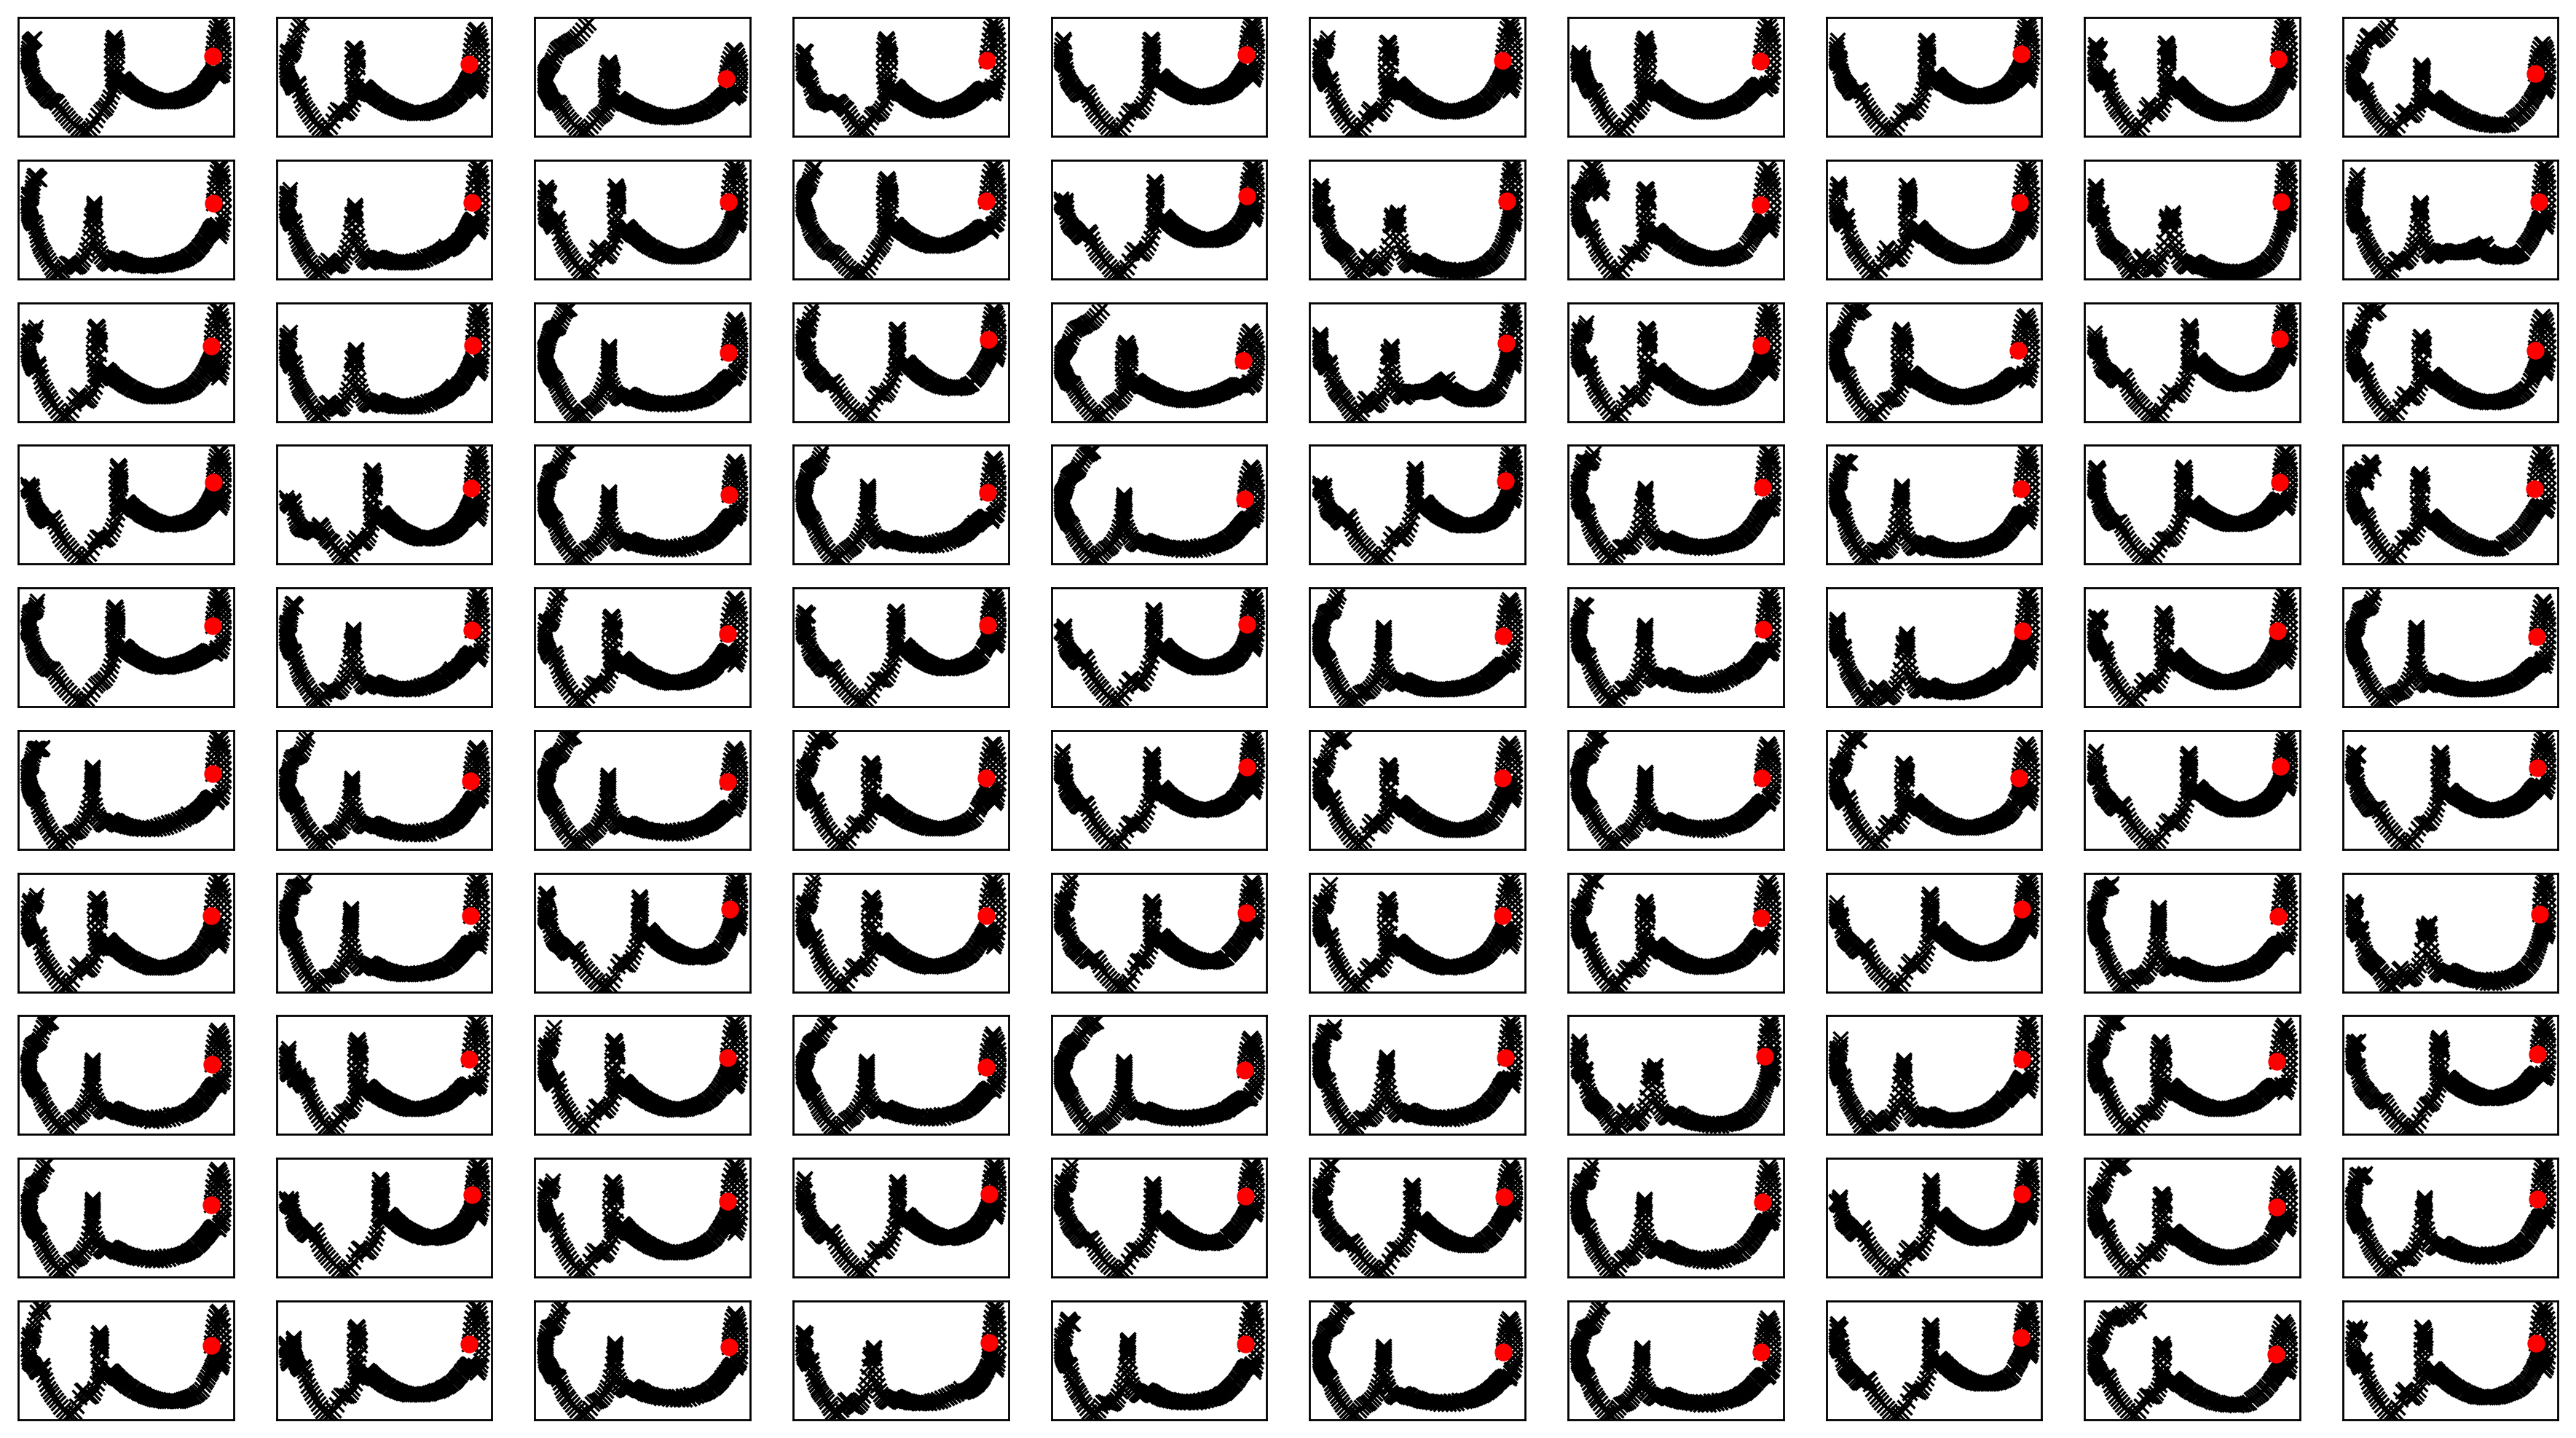

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

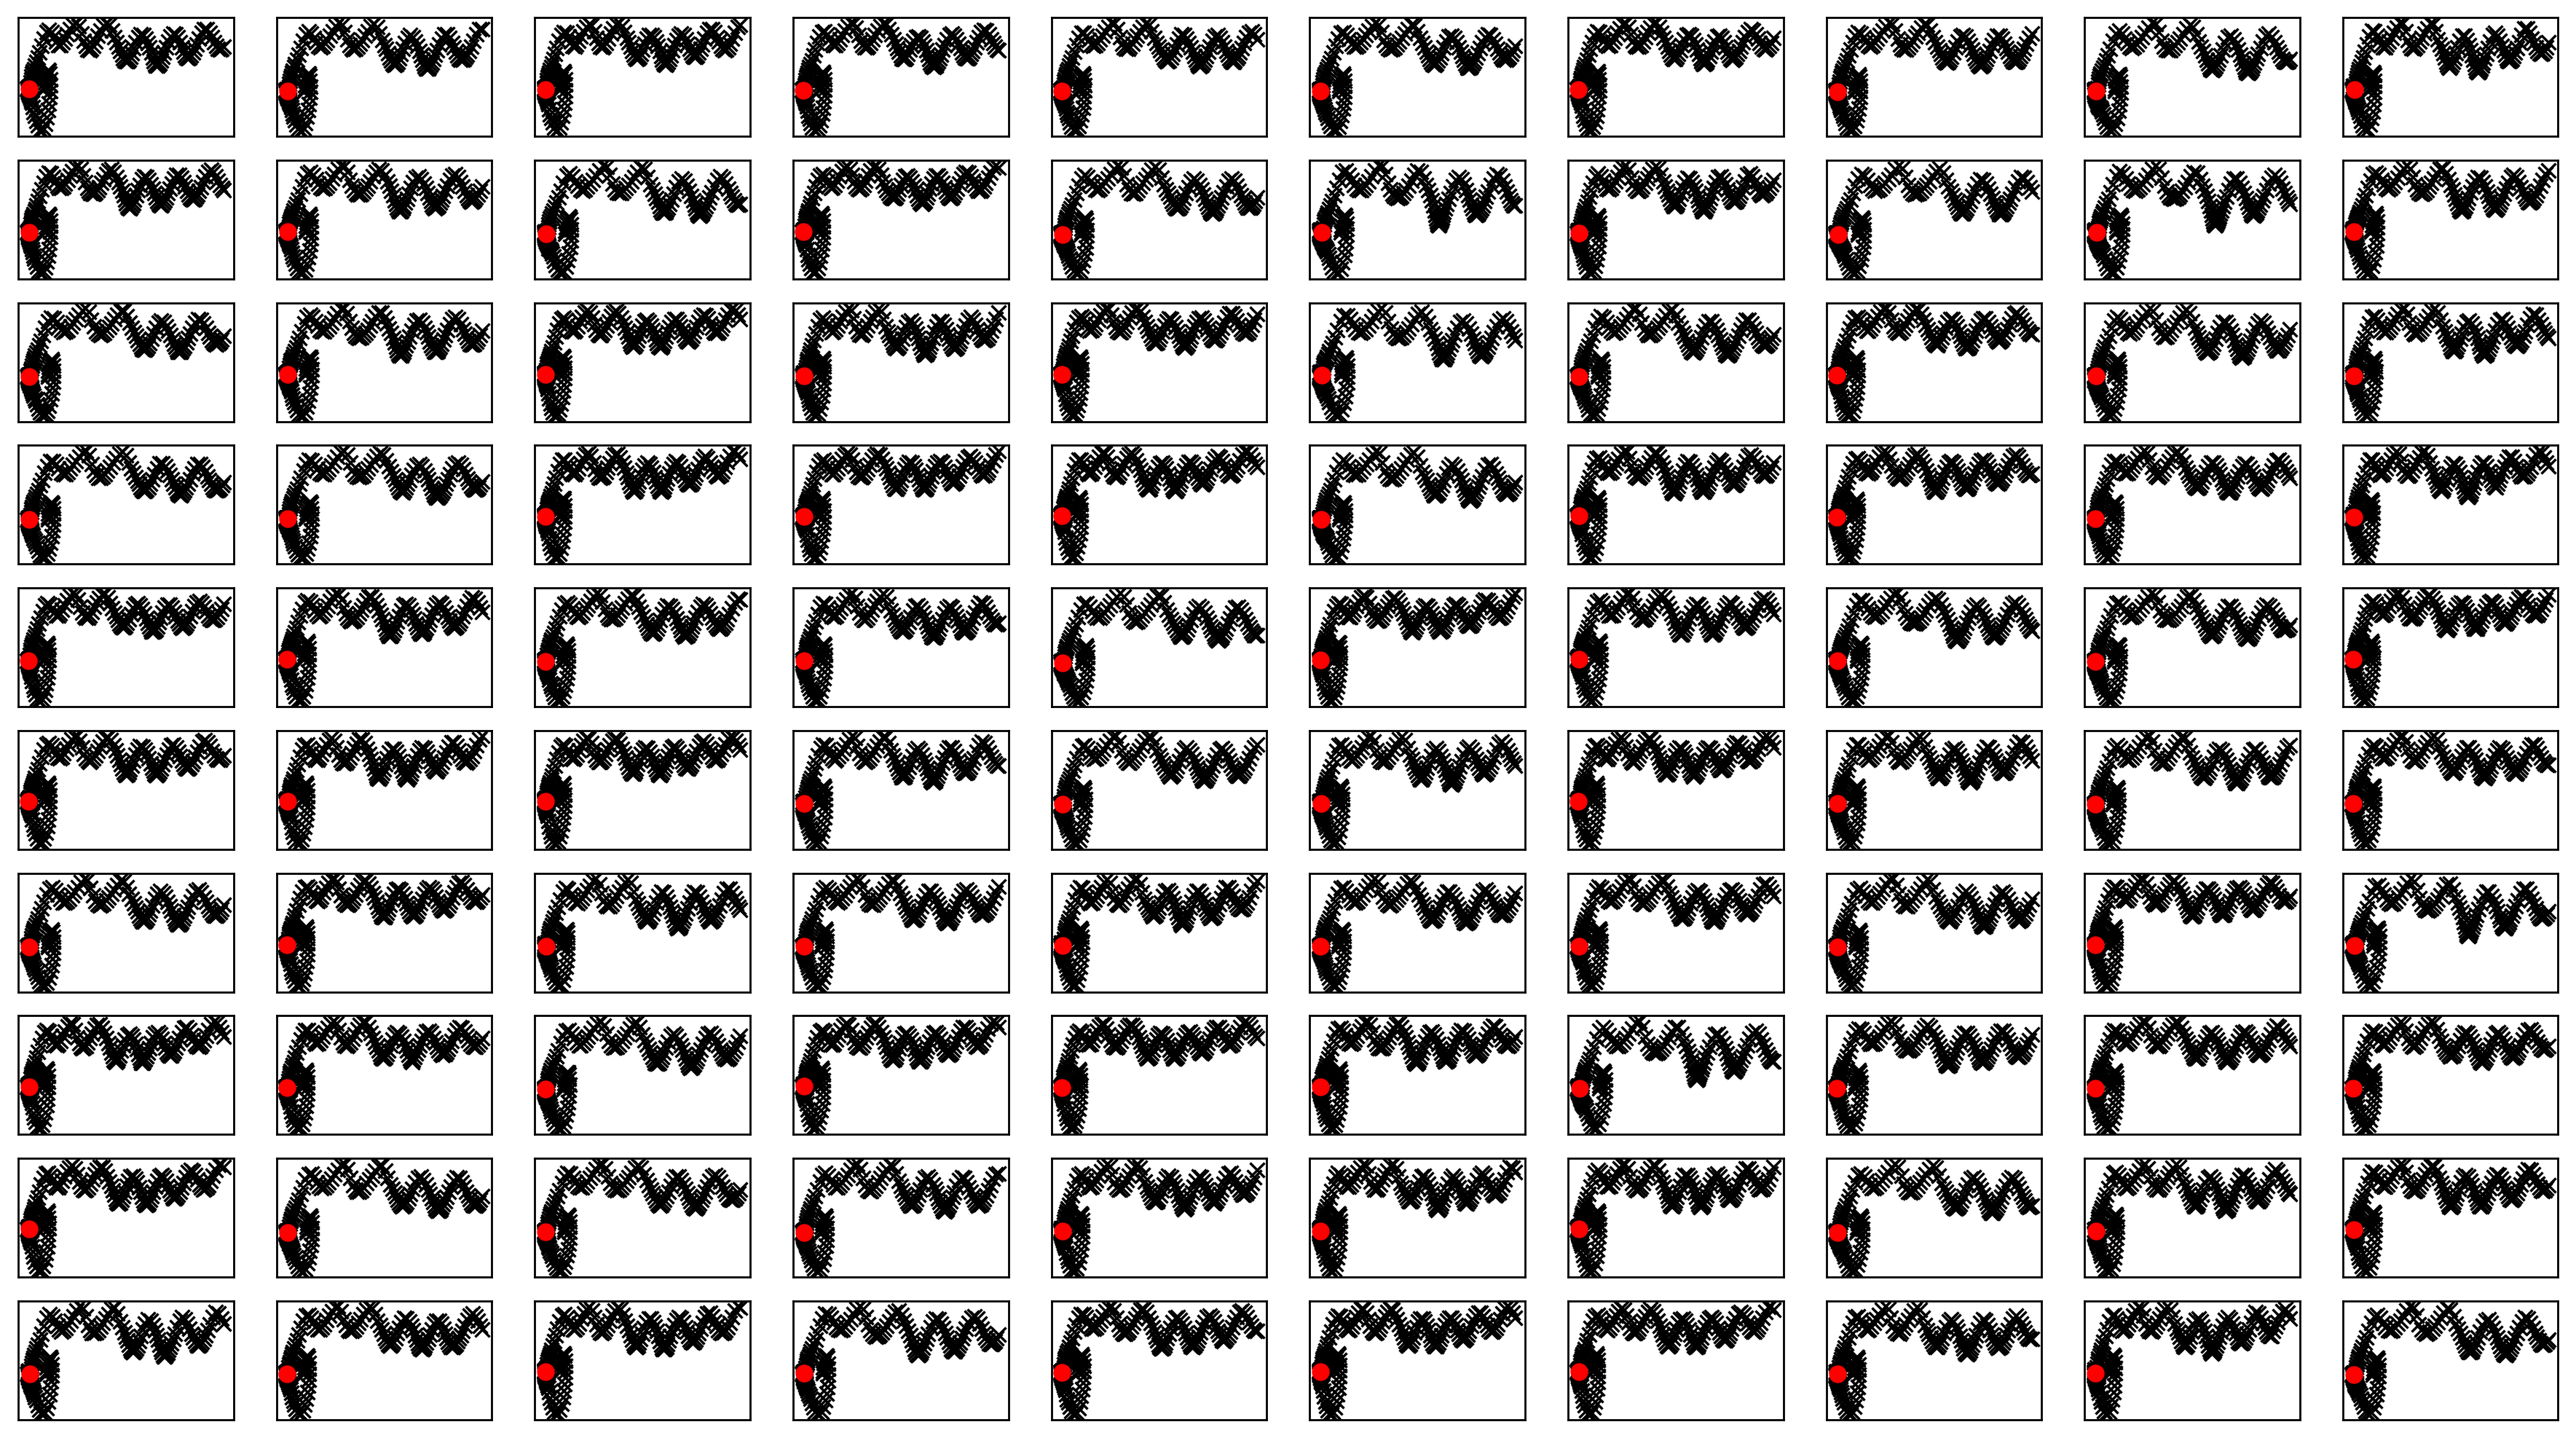

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-29 23:59:41.499712


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3
predict diverge [-13.61392116  31.9725054   75.96573895  32.5514205 ] [ 0.42149679 19.2259666   1.37984579  0.92138558] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 141

 4

 5

 6

 7

 8

 9
predict diverge [-18.56795336 -19.06422026  92.19598626  26.35918481] [-0.71109508 -2.22759881  0.96624297 -0.88964539] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 138

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47
predict diverge [-3.06084311 19.51128949 87.61389916 22.26347511] [0.62425049 1.20787641 1.14639502 1.59777208] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 170

 48
predict diverge [  4.04828289 -48.1388193   99.3051471   35.33032922] [  0.15620624 -5

In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.34247  validloss 1.39823±0.00000  bestvalidloss 1.39823  last_update 0
train: iter 1  trainloss 1.25207  validloss 1.29130±0.00000  bestvalidloss 1.29130  last_update 0
train: iter 2  trainloss 1.19494  validloss 1.22224±0.00000  bestvalidloss 1.22224  last_update 0
train: iter 3  trainloss 1.14224  validloss 1.18123±0.00000  bestvalidloss 1.18123  last_update 0
train: iter 4  trainloss 1.07288  validloss 1.13168±0.00000  bestvalidloss 1.13168  last_update 0
train: iter 5  trainloss 1.00406  validloss 1.06706±0.00000  bestvalidloss 1.06706  last_update 0
train: iter 6  trainloss 0.94648  validloss 1.01065±0.00000  bestvalidloss 1.01065  last_update 0
train: iter 7  trainloss 0.89441  validloss 0.95972±0.00000  bestvalidloss 0.95972  last_update 0
train: iter 8  trainloss 0.85003  validloss 0.91298±0.00000  bestvalidloss 0.91298  last_update 0
train: iter 9  trainloss 0.80887  validloss 0.87310±0.00000  bestvalidloss 0.87310  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.41944  validloss 0.42100±0.00000  bestvalidloss 0.42037  last_update 3
train: iter 84  trainloss 0.41953  validloss 0.42720±0.00000  bestvalidloss 0.42037  last_update 4
train: iter 85  trainloss 0.41215  validloss 0.43090±0.00000  bestvalidloss 0.42037  last_update 5
train: iter 86  trainloss 0.41234  validloss 0.42656±0.00000  bestvalidloss 0.42037  last_update 6
train: iter 87  trainloss 0.41290  validloss 0.42243±0.00000  bestvalidloss 0.42037  last_update 7
train: iter 88  trainloss 0.41160  validloss 0.43853±0.00000  bestvalidloss 0.42037  last_update 8
train: iter 89  trainloss 0.40890  validloss 0.42732±0.00000  bestvalidloss 0.42037  last_update 9
train: iter 90  trainloss 0.42536  validloss 0.41033±0.00000  bestvalidloss 0.41033  last_update 0
train: iter 91  trainloss 0.41423  validloss 0.44003±0.00000  bestvalidloss 0.41033  last_update 1
train: iter 92  trainloss 0.41092  validloss 0.41988±0.00000  bestvalidloss 0.41033  last_update 2
train: ite

train: iter 165  trainloss 0.36950  validloss 0.40495±0.00000  bestvalidloss 0.39518  last_update 33
train: iter 166  trainloss 0.36853  validloss 0.42640±0.00000  bestvalidloss 0.39518  last_update 34
train: iter 167  trainloss 0.36802  validloss 0.40583±0.00000  bestvalidloss 0.39518  last_update 35
train: iter 168  trainloss 0.37167  validloss 0.40906±0.00000  bestvalidloss 0.39518  last_update 36
train: iter 169  trainloss 0.36612  validloss 0.42190±0.00000  bestvalidloss 0.39518  last_update 37
train: iter 170  trainloss 0.36951  validloss 0.41324±0.00000  bestvalidloss 0.39518  last_update 38
train: iter 171  trainloss 0.36787  validloss 0.43548±0.00000  bestvalidloss 0.39518  last_update 39
train: iter 172  trainloss 0.37007  validloss 0.39710±0.00000  bestvalidloss 0.39518  last_update 40
train: iter 173  trainloss 0.37136  validloss 0.39637±0.00000  bestvalidloss 0.39518  last_update 41
train: iter 174  trainloss 0.37169  validloss 0.42364±0.00000  bestvalidloss 0.39518  last_

train: iter 247  trainloss 0.34619  validloss 0.41113±0.00000  bestvalidloss 0.38343  last_update 6
train: iter 248  trainloss 0.35219  validloss 0.40477±0.00000  bestvalidloss 0.38343  last_update 7
train: iter 249  trainloss 0.34871  validloss 0.40389±0.00000  bestvalidloss 0.38343  last_update 8
train: iter 250  trainloss 0.33898  validloss 0.38516±0.00000  bestvalidloss 0.38343  last_update 9
train: iter 251  trainloss 0.33581  validloss 0.37812±0.00000  bestvalidloss 0.37812  last_update 0
train: iter 252  trainloss 0.34684  validloss 0.38685±0.00000  bestvalidloss 0.37812  last_update 1
train: iter 253  trainloss 0.33752  validloss 0.38672±0.00000  bestvalidloss 0.37812  last_update 2
train: iter 254  trainloss 0.33908  validloss 0.38855±0.00000  bestvalidloss 0.37812  last_update 3
train: iter 255  trainloss 0.33614  validloss 0.38491±0.00000  bestvalidloss 0.37812  last_update 4
train: iter 256  trainloss 0.33563  validloss 0.38787±0.00000  bestvalidloss 0.37812  last_update 5


train: iter 329  trainloss 0.32524  validloss 0.36615±0.00000  bestvalidloss 0.36188  last_update 3
train: iter 330  trainloss 0.31895  validloss 0.35722±0.00000  bestvalidloss 0.35722  last_update 0
train: iter 331  trainloss 0.32106  validloss 0.37143±0.00000  bestvalidloss 0.35722  last_update 1
train: iter 332  trainloss 0.32335  validloss 0.37418±0.00000  bestvalidloss 0.35722  last_update 2
train: iter 333  trainloss 0.31918  validloss 0.36134±0.00000  bestvalidloss 0.35722  last_update 3
train: iter 334  trainloss 0.31355  validloss 0.36616±0.00000  bestvalidloss 0.35722  last_update 4
train: iter 335  trainloss 0.31498  validloss 0.38182±0.00000  bestvalidloss 0.35722  last_update 5
train: iter 336  trainloss 0.31503  validloss 0.37140±0.00000  bestvalidloss 0.35722  last_update 6
train: iter 337  trainloss 0.32025  validloss 0.41379±0.00000  bestvalidloss 0.35722  last_update 7
train: iter 338  trainloss 0.32099  validloss 0.36302±0.00000  bestvalidloss 0.35722  last_update 8


train: iter 411  trainloss 0.30015  validloss 0.34475±0.00000  bestvalidloss 0.34475  last_update 0
train: iter 412  trainloss 0.29884  validloss 0.34713±0.00000  bestvalidloss 0.34475  last_update 1
train: iter 413  trainloss 0.30114  validloss 0.38803±0.00000  bestvalidloss 0.34475  last_update 2
train: iter 414  trainloss 0.29676  validloss 0.34060±0.00000  bestvalidloss 0.34060  last_update 0
train: iter 415  trainloss 0.29883  validloss 0.34450±0.00000  bestvalidloss 0.34060  last_update 1
train: iter 416  trainloss 0.30064  validloss 0.34935±0.00000  bestvalidloss 0.34060  last_update 2
train: iter 417  trainloss 0.29579  validloss 0.34947±0.00000  bestvalidloss 0.34060  last_update 3
train: iter 418  trainloss 0.29928  validloss 0.35874±0.00000  bestvalidloss 0.34060  last_update 4
train: iter 419  trainloss 0.29829  validloss 0.34351±0.00000  bestvalidloss 0.34060  last_update 5
train: iter 420  trainloss 0.30720  validloss 0.34518±0.00000  bestvalidloss 0.34060  last_update 6


train: iter 493  trainloss 0.28672  validloss 0.36961±0.00000  bestvalidloss 0.32538  last_update 10
train: iter 494  trainloss 0.28076  validloss 0.34142±0.00000  bestvalidloss 0.32538  last_update 11
train: iter 495  trainloss 0.28405  validloss 0.32200±0.00000  bestvalidloss 0.32200  last_update 0
train: iter 496  trainloss 0.27811  validloss 0.32760±0.00000  bestvalidloss 0.32200  last_update 1
train: iter 497  trainloss 0.28351  validloss 0.33533±0.00000  bestvalidloss 0.32200  last_update 2
train: iter 498  trainloss 0.28085  validloss 0.33070±0.00000  bestvalidloss 0.32200  last_update 3
train: iter 499  trainloss 0.27890  validloss 0.32278±0.00000  bestvalidloss 0.32200  last_update 4
train: iter 500  trainloss 0.28668  validloss 0.31954±0.00000  bestvalidloss 0.31954  last_update 0
train: iter 501  trainloss 0.28687  validloss 0.35000±0.00000  bestvalidloss 0.31954  last_update 1
train: iter 502  trainloss 0.28317  validloss 0.32989±0.00000  bestvalidloss 0.31954  last_update 

train: iter 575  trainloss 0.27208  validloss 0.32687±0.00000  bestvalidloss 0.31156  last_update 8
train: iter 576  trainloss 0.27226  validloss 0.32224±0.00000  bestvalidloss 0.31156  last_update 9
train: iter 577  trainloss 0.26989  validloss 0.31804±0.00000  bestvalidloss 0.31156  last_update 10
train: iter 578  trainloss 0.26988  validloss 0.33084±0.00000  bestvalidloss 0.31156  last_update 11
train: iter 579  trainloss 0.26989  validloss 0.32050±0.00000  bestvalidloss 0.31156  last_update 12
train: iter 580  trainloss 0.27070  validloss 0.31445±0.00000  bestvalidloss 0.31156  last_update 13
train: iter 581  trainloss 0.27062  validloss 0.31622±0.00000  bestvalidloss 0.31156  last_update 14
train: iter 582  trainloss 0.26855  validloss 0.32091±0.00000  bestvalidloss 0.31156  last_update 15
train: iter 583  trainloss 0.26840  validloss 0.31792±0.00000  bestvalidloss 0.31156  last_update 16
train: iter 584  trainloss 0.27368  validloss 0.32222±0.00000  bestvalidloss 0.31156  last_up

train: iter 657  trainloss 0.25890  validloss 0.32117±0.00000  bestvalidloss 0.30817  last_update 43
train: iter 658  trainloss 0.25722  validloss 0.32207±0.00000  bestvalidloss 0.30817  last_update 44
train: iter 659  trainloss 0.25994  validloss 0.32751±0.00000  bestvalidloss 0.30817  last_update 45
train: iter 660  trainloss 0.25853  validloss 0.32023±0.00000  bestvalidloss 0.30817  last_update 46
train: iter 661  trainloss 0.26280  validloss 0.32326±0.00000  bestvalidloss 0.30817  last_update 47
train: iter 662  trainloss 0.26335  validloss 0.32829±0.00000  bestvalidloss 0.30817  last_update 48
train: iter 663  trainloss 0.25642  validloss 0.32783±0.00000  bestvalidloss 0.30817  last_update 49
train: iter 664  trainloss 0.26080  validloss 0.35108±0.00000  bestvalidloss 0.30817  last_update 50
train: iter 665  trainloss 0.26009  validloss 0.33973±0.00000  bestvalidloss 0.30817  last_update 51
train: iter 666  trainloss 0.25905  validloss 0.32329±0.00000  bestvalidloss 0.30817  last_

train_loss:  -2.70832332946062
valid_loss:  -2.1413985696673388
weight_alpha 1.0 h_min_tilde -11.708967 ell_tilde -2.594938377501964 kappa_tilde 0.0003312415444733718
train_loss:  -3.3660990714073185
valid_loss:  -3.0737764045715337
weight_alpha 0.1 h_min_tilde -11.708967 ell_tilde -3.307634538040162 kappa_tilde 0.00034500541297994604


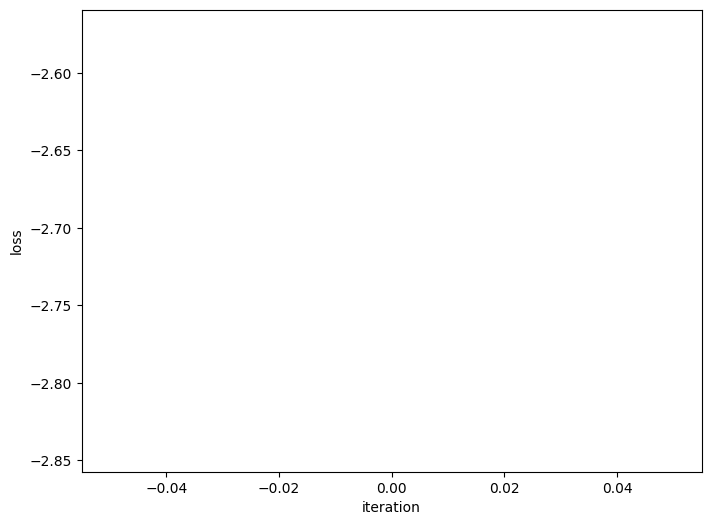

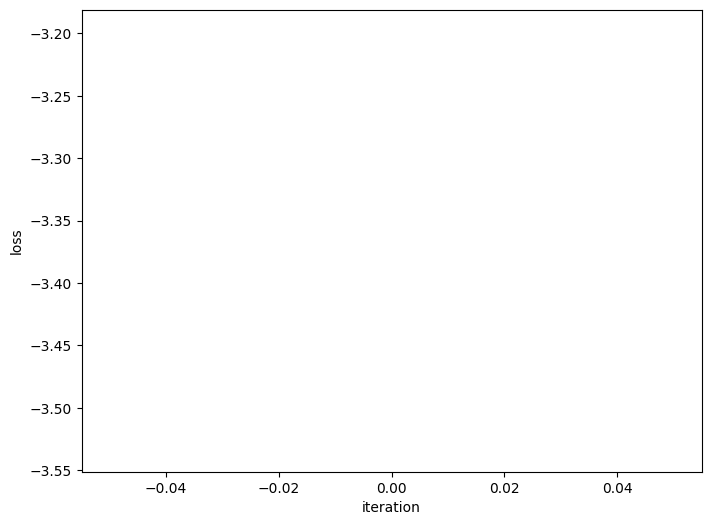

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -650.67650  validloss -615.96851±0.00000  bestvalidloss -615.96851  last_update 0
train: iter 1  trainloss -648.77788  validloss -608.53952±0.00000  bestvalidloss -615.96851  last_update 1
train: iter 2  trainloss -666.43847  validloss -587.28234±0.00000  bestvalidloss -615.96851  last_update 2
train: iter 3  trainloss -652.67427  validloss -559.64192±0.00000  bestvalidloss -615.96851  last_update 3
train: iter 4  trainloss -636.79737  validloss -577.34008±0.00000  bestvalidloss -615.96851  last_update 4
train: iter 5  trainloss -657.56598  validloss -578.25291±0.00000  bestvalidloss -615.96851  last_update 5
train: iter 6  trainloss -665.11228  validloss -607.84669±0.00000  bestvalidloss -615.96851  last_update 6
train: iter 7  trainloss -667.14211  validloss -612.93571±0.00000  bestvalidloss -615.96851  last_update 7
train: iter 8  trainloss -658.51982  validloss -579.30230±0.00000  bestvalidloss -615.96851  last_u

train: iter 76  trainloss -679.95289  validloss -614.17971±0.00000  bestvalidloss -619.79759  last_update 32
train: iter 77  trainloss -677.28001  validloss -613.12598±0.00000  bestvalidloss -619.79759  last_update 33
train: iter 78  trainloss -629.25621  validloss -604.94870±0.00000  bestvalidloss -619.79759  last_update 34
train: iter 79  trainloss -656.19751  validloss -444.53628±0.00000  bestvalidloss -619.79759  last_update 35
train: iter 80  trainloss -675.52075  validloss -599.15604±0.00000  bestvalidloss -619.79759  last_update 36
train: iter 81  trainloss -675.63924  validloss -581.07327±0.00000  bestvalidloss -619.79759  last_update 37
train: iter 82  trainloss -680.89303  validloss -601.97999±0.00000  bestvalidloss -619.79759  last_update 38
train: iter 83  trainloss -656.83999  validloss -579.66475±0.00000  bestvalidloss -619.79759  last_update 39
train: iter 84  trainloss -671.83075  validloss -581.86737±0.00000  bestvalidloss -619.79759  last_update 40
train: iter 85  tra

train: iter 151  trainloss -670.88850  validloss -594.30860±0.00000  bestvalidloss -626.84444  last_update 15
train: iter 152  trainloss -692.69754  validloss -611.20367±0.00000  bestvalidloss -626.84444  last_update 16
train: iter 153  trainloss -693.58868  validloss -618.97339±0.00000  bestvalidloss -626.84444  last_update 17
train: iter 154  trainloss -686.49581  validloss -627.24614±0.00000  bestvalidloss -627.24614  last_update 0
train: iter 155  trainloss -531.49680  validloss -51.46179±0.00000  bestvalidloss -627.24614  last_update 1
train: iter 156  trainloss -657.74794  validloss -524.42942±0.00000  bestvalidloss -627.24614  last_update 2
train: iter 157  trainloss -679.15331  validloss -574.29029±0.00000  bestvalidloss -627.24614  last_update 3
train: iter 158  trainloss -678.73033  validloss -579.87059±0.00000  bestvalidloss -627.24614  last_update 4
train: iter 159  trainloss -691.80777  validloss -573.72414±0.00000  bestvalidloss -627.24614  last_update 5
train: iter 160  

train: iter 226  trainloss -699.73406  validloss -593.60579±0.00000  bestvalidloss -633.12685  last_update 9
train: iter 227  trainloss -703.91219  validloss -598.84256±0.00000  bestvalidloss -633.12685  last_update 10
train: iter 228  trainloss -706.28841  validloss -580.38463±0.00000  bestvalidloss -633.12685  last_update 11
train: iter 229  trainloss -700.98794  validloss -606.47619±0.00000  bestvalidloss -633.12685  last_update 12
train: iter 230  trainloss -698.08694  validloss -594.63970±0.00000  bestvalidloss -633.12685  last_update 13
train: iter 231  trainloss -696.44470  validloss -602.72140±0.00000  bestvalidloss -633.12685  last_update 14
train: iter 232  trainloss -679.87284  validloss -582.40109±0.00000  bestvalidloss -633.12685  last_update 15
train: iter 233  trainloss -702.09563  validloss -586.79644±0.00000  bestvalidloss -633.12685  last_update 16
train: iter 234  trainloss -681.46295  validloss -609.03369±0.00000  bestvalidloss -633.12685  last_update 17
train: iter

train: iter 301  trainloss -715.32223  validloss -630.80059±0.00000  bestvalidloss -633.12685  last_update 84
train: iter 302  trainloss -719.11470  validloss -634.92038±0.00000  bestvalidloss -634.92038  last_update 0
train: iter 303  trainloss -715.73771  validloss -635.69794±0.00000  bestvalidloss -635.69794  last_update 0
train: iter 304  trainloss -664.85815  validloss -584.41688±0.00000  bestvalidloss -635.69794  last_update 1
train: iter 305  trainloss -688.91759  validloss -396.73387±0.00000  bestvalidloss -635.69794  last_update 2
train: iter 306  trainloss -723.10845  validloss -598.12455±0.00000  bestvalidloss -635.69794  last_update 3
train: iter 307  trainloss -725.04384  validloss -614.36222±0.00000  bestvalidloss -635.69794  last_update 4
train: iter 308  trainloss -692.32163  validloss -586.48606±0.00000  bestvalidloss -635.69794  last_update 5
train: iter 309  trainloss -722.52507  validloss -620.44806±0.00000  bestvalidloss -635.69794  last_update 6
train: iter 310  t

train: iter 376  trainloss -725.06549  validloss -590.77894±0.00000  bestvalidloss -641.05480  last_update 19
train: iter 377  trainloss -720.34418  validloss -587.88801±0.00000  bestvalidloss -641.05480  last_update 20
train: iter 378  trainloss -730.42377  validloss -609.15848±0.00000  bestvalidloss -641.05480  last_update 21
train: iter 379  trainloss -717.16923  validloss -605.73169±0.00000  bestvalidloss -641.05480  last_update 22
train: iter 380  trainloss -720.28386  validloss -579.80770±0.00000  bestvalidloss -641.05480  last_update 23
train: iter 381  trainloss -731.53094  validloss -593.88130±0.00000  bestvalidloss -641.05480  last_update 24
train: iter 382  trainloss -734.36259  validloss -619.64984±0.00000  bestvalidloss -641.05480  last_update 25
train: iter 383  trainloss -731.91631  validloss -585.42151±0.00000  bestvalidloss -641.05480  last_update 26
train: iter 384  trainloss -693.93972  validloss -615.27380±0.00000  bestvalidloss -641.05480  last_update 27
train: ite

train: iter 451  trainloss -683.36336  validloss -594.60597±0.00000  bestvalidloss -652.52200  last_update 38
train: iter 452  trainloss -722.91780  validloss -529.31959±0.00000  bestvalidloss -652.52200  last_update 39
train: iter 453  trainloss -743.60359  validloss -617.72197±0.00000  bestvalidloss -652.52200  last_update 40
train: iter 454  trainloss -746.51571  validloss -623.96303±0.00000  bestvalidloss -652.52200  last_update 41
train: iter 455  trainloss -738.09868  validloss -592.99173±0.00000  bestvalidloss -652.52200  last_update 42
train: iter 456  trainloss -733.90320  validloss -589.98676±0.00000  bestvalidloss -652.52200  last_update 43
train: iter 457  trainloss -739.76462  validloss -643.23854±0.00000  bestvalidloss -652.52200  last_update 44
train: iter 458  trainloss -726.87497  validloss -518.34653±0.00000  bestvalidloss -652.52200  last_update 45
train: iter 459  trainloss -753.38729  validloss -626.86438±0.00000  bestvalidloss -652.52200  last_update 46
train: ite

train: iter 526  trainloss -760.13034  validloss -663.28799±0.00000  bestvalidloss -681.49325  last_update 24
train: iter 527  trainloss -690.89472  validloss -636.20571±0.00000  bestvalidloss -681.49325  last_update 25
train: iter 528  trainloss -735.81779  validloss -581.16147±0.00000  bestvalidloss -681.49325  last_update 26
train: iter 529  trainloss -760.03741  validloss -635.59590±0.00000  bestvalidloss -681.49325  last_update 27
train: iter 530  trainloss -757.11922  validloss -605.81592±0.00000  bestvalidloss -681.49325  last_update 28
train: iter 531  trainloss -755.85516  validloss -614.03706±0.00000  bestvalidloss -681.49325  last_update 29
train: iter 532  trainloss -757.77624  validloss -626.59188±0.00000  bestvalidloss -681.49325  last_update 30
train: iter 533  trainloss -764.07182  validloss -611.29497±0.00000  bestvalidloss -681.49325  last_update 31
train: iter 534  trainloss -747.78896  validloss -624.86026±0.00000  bestvalidloss -681.49325  last_update 32
train: ite

train: iter 601  trainloss -771.13081  validloss -632.17781±0.00000  bestvalidloss -692.31862  last_update 20
train: iter 602  trainloss -774.98036  validloss -639.81621±0.00000  bestvalidloss -692.31862  last_update 21
train: iter 603  trainloss -774.79304  validloss -596.08438±0.00000  bestvalidloss -692.31862  last_update 22
train: iter 604  trainloss -699.15307  validloss -617.44160±0.00000  bestvalidloss -692.31862  last_update 23
train: iter 605  trainloss -773.28101  validloss -621.72544±0.00000  bestvalidloss -692.31862  last_update 24
train: iter 606  trainloss -773.23378  validloss -628.67312±0.00000  bestvalidloss -692.31862  last_update 25
train: iter 607  trainloss -775.40510  validloss -631.01835±0.00000  bestvalidloss -692.31862  last_update 26
train: iter 608  trainloss -767.50177  validloss -635.08566±0.00000  bestvalidloss -692.31862  last_update 27
train: iter 609  trainloss -772.20134  validloss -648.02151±0.00000  bestvalidloss -692.31862  last_update 28
train: ite

train: iter 676  trainloss -782.44875  validloss -645.47828±0.00000  bestvalidloss -692.31862  last_update 95
train: iter 677  trainloss -767.24825  validloss -622.29214±0.00000  bestvalidloss -692.31862  last_update 96
train: iter 678  trainloss -777.33097  validloss -645.97773±0.00000  bestvalidloss -692.31862  last_update 97
train: iter 679  trainloss -792.17229  validloss -667.04366±0.00000  bestvalidloss -692.31862  last_update 98
train: iter 680  trainloss -784.78645  validloss -636.64343±0.00000  bestvalidloss -692.31862  last_update 99
train: iter 681  trainloss -761.07798  validloss -639.73650±0.00000  bestvalidloss -692.31862  last_update 100
train: fin
penalty_target_min tensor(-11.8265) penalty_target_max tensor(29.0618)


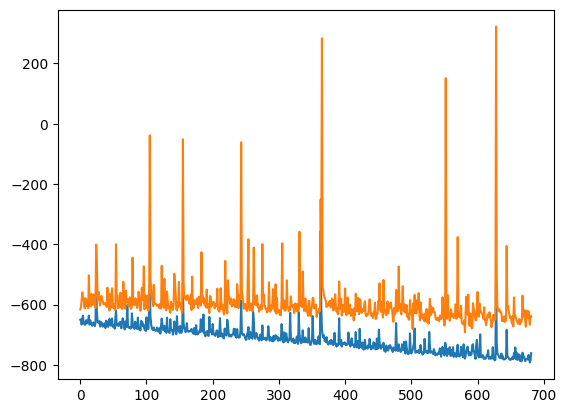

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-30 00:28:58.791415


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.57307  validloss 0.96689±0.00000  bestvalidloss 0.96689  last_update 0
train: iter 1  trainloss 0.46929  validloss 0.49249±0.00000  bestvalidloss 0.49249  last_update 0
train: iter 2  trainloss 0.44560  validloss 0.49723±0.00000  bestvalidloss 0.49249  last_update 1
train: iter 3  trainloss 0.43736  validloss 0.49613±0.00000  bestvalidloss 0.49249  last_update 2
train: iter 4  trainloss 0.41747  validloss 0.45919±0.00000  bestvalidloss 0.45919  last_update 0
train: iter 5  trainloss 0.40966  validloss 0.46044±0.00000  bestvalidloss 0.45919  last_update 1
train: iter 6  trainloss 0.40105  validloss 0.45152±0.00000  bestvalidloss 0.45152  last_update 0
train: iter 7  trainloss 0.40208  validloss 0.44538±0.00000  bestvalidloss 0.44538  last_update 0
train: iter 8  trainloss 0.39490  validloss 0.43759±0.00000  bestvalidloss 0.43759  last_update 0
train: iter 9  trainloss 0.39724  validloss 0.43236±0.00000  bestvalidloss 0.43236  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.33935  validloss 0.38799±0.00000  bestvalidloss 0.38799  last_update 0
train: iter 85  trainloss 0.33796  validloss 0.41956±0.00000  bestvalidloss 0.38799  last_update 1
train: iter 86  trainloss 0.34765  validloss 0.42185±0.00000  bestvalidloss 0.38799  last_update 2
train: iter 87  trainloss 0.33669  validloss 0.41775±0.00000  bestvalidloss 0.38799  last_update 3
train: iter 88  trainloss 0.34908  validloss 0.41394±0.00000  bestvalidloss 0.38799  last_update 4
train: iter 89  trainloss 0.34524  validloss 0.40379±0.00000  bestvalidloss 0.38799  last_update 5
train: iter 90  trainloss 0.34033  validloss 0.40587±0.00000  bestvalidloss 0.38799  last_update 6
train: iter 91  trainloss 0.34237  validloss 0.40982±0.00000  bestvalidloss 0.38799  last_update 7
train: iter 92  trainloss 0.34342  validloss 0.40956±0.00000  bestvalidloss 0.38799  last_update 8
train: iter 93  trainloss 0.34680  validloss 0.39297±0.00000  bestvalidloss 0.38799  last_update 9
train: ite

train: iter 166  trainloss 0.32405  validloss 0.39789±0.00000  bestvalidloss 0.38097  last_update 32
train: iter 167  trainloss 0.32557  validloss 0.39326±0.00000  bestvalidloss 0.38097  last_update 33
train: iter 168  trainloss 0.32956  validloss 0.39662±0.00000  bestvalidloss 0.38097  last_update 34
train: iter 169  trainloss 0.32121  validloss 0.41188±0.00000  bestvalidloss 0.38097  last_update 35
train: iter 170  trainloss 0.32443  validloss 0.39571±0.00000  bestvalidloss 0.38097  last_update 36
train: iter 171  trainloss 0.31902  validloss 0.38407±0.00000  bestvalidloss 0.38097  last_update 37
train: iter 172  trainloss 0.32692  validloss 0.39835±0.00000  bestvalidloss 0.38097  last_update 38
train: iter 173  trainloss 0.33058  validloss 0.38846±0.00000  bestvalidloss 0.38097  last_update 39
train: iter 174  trainloss 0.32424  validloss 0.39268±0.00000  bestvalidloss 0.38097  last_update 40
train: iter 175  trainloss 0.32412  validloss 0.39002±0.00000  bestvalidloss 0.38097  last_

train_loss:  -3.195965134477615
valid_loss:  -0.8447827938199044
weight_alpha 1.0 h_min_tilde -11.826509 ell_tilde -2.725728666346073 kappa_tilde 0.0003314825512347135
train_loss:  -4.090123228311539
valid_loss:  -3.4032478191375732
weight_alpha 0.1 h_min_tilde -11.826509 ell_tilde -3.952748146476746 kappa_tilde 0.00035637635114219225


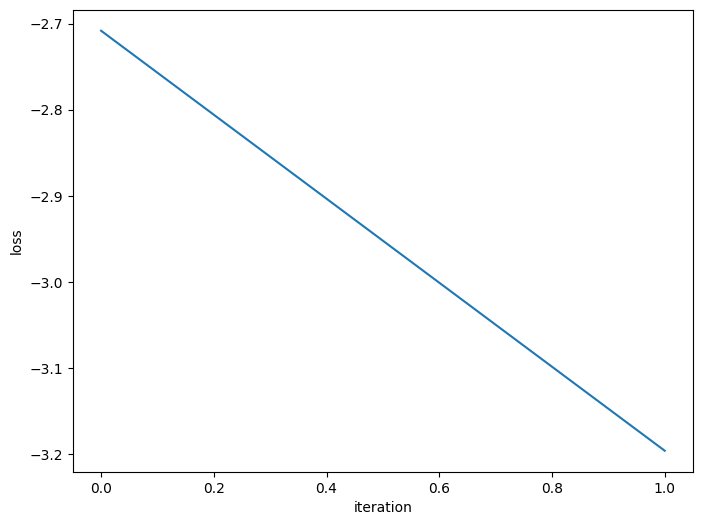

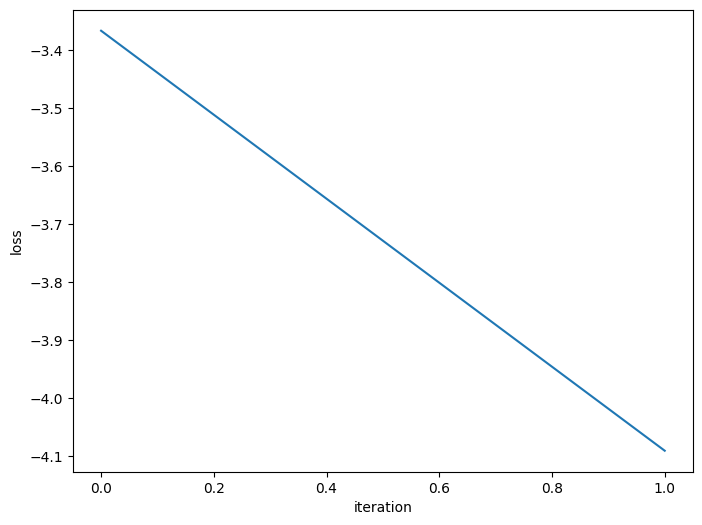

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -831.79257  validloss -681.82238±0.00000  bestvalidloss -681.82238  last_update 0
train: iter 1  trainloss -797.65804  validloss -729.98746±0.00000  bestvalidloss -729.98746  last_update 0
train: iter 2  trainloss -842.24179  validloss -688.95971±0.00000  bestvalidloss -729.98746  last_update 1
train: iter 3  trainloss -806.28024  validloss -710.85443±0.00000  bestvalidloss -729.98746  last_update 2
train: iter 4  trainloss -830.57113  validloss -717.41413±0.00000  bestvalidloss -729.98746  last_update 3
train: iter 5  trainloss -839.63192  validloss -711.82020±0.00000  bestvalidloss -729.98746  last_update 4
train: iter 6  trainloss -808.64505  validloss -760.33206±0.00000  bestvalidloss -760.33206  last_update 0
train: iter 7  trainloss -800.68157  validloss -670.86827±0.00000  bestvalidloss -760.33206  last_update 1
train: iter 8  trainloss -809.38595  validloss -610.97027±0.00000  bestvalidloss -760.33206  last_u

train: iter 75  trainloss -804.94675  validloss -713.68154±0.00000  bestvalidloss -760.33206  last_update 69
train: iter 76  trainloss -844.83135  validloss -732.16496±0.00000  bestvalidloss -760.33206  last_update 70
train: iter 77  trainloss -805.89871  validloss -709.72023±0.00000  bestvalidloss -760.33206  last_update 71
train: iter 78  trainloss -832.73438  validloss -720.20054±0.00000  bestvalidloss -760.33206  last_update 72
train: iter 79  trainloss -831.55860  validloss -736.44273±0.00000  bestvalidloss -760.33206  last_update 73
train: iter 80  trainloss -821.18977  validloss -744.47911±0.00000  bestvalidloss -760.33206  last_update 74
train: iter 81  trainloss -823.78209  validloss -698.69254±0.00000  bestvalidloss -760.33206  last_update 75
train: iter 82  trainloss -834.44848  validloss -723.83346±0.00000  bestvalidloss -760.33206  last_update 76
train: iter 83  trainloss -817.75904  validloss -719.49136±0.00000  bestvalidloss -760.33206  last_update 77
train: iter 84  tra

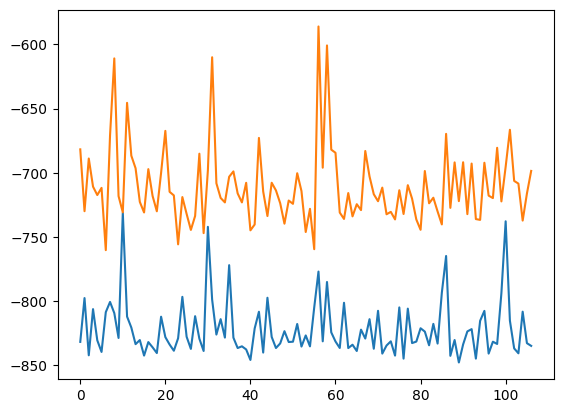

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-30 00:52:27.621166


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43
predict diverge [-17.93086914   2.14255172  14.4610594   34.84445994] [ 0.07776679  0.83521684  0.95282114 12.70529935] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 161

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80
predict diverge [-33.78110641 -21.54688237  90.13659578  14.94994033] [-0.45852856 -6.38861607  0.59710909 -0.42644558] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 187

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.38144  validloss 0.43249±0.00000  bestvalidloss 0.43249  last_update 0
train: iter 1  trainloss 0.37400  validloss 0.42763±0.00000  bestvalidloss 0.42763  last_update 0
train: iter 2  trainloss 0.36074  validloss 0.42312±0.00000  bestvalidloss 0.42312  last_update 0
train: iter 3  trainloss 0.36238  validloss 0.40286±0.00000  bestvalidloss 0.40286  last_update 0
train: iter 4  trainloss 0.35954  validloss 0.39924±0.00000  bestvalidloss 0.39924  last_update 0
train: iter 5  trainloss 0.36009  validloss 0.39177±0.00000  bestvalidloss 0.39177  last_update 0
train: iter 6  trainloss 0.36420  validloss 0.39659±0.00000  bestvalidloss 0.39177  last_update 1
train: iter 7  trainloss 0.35569  validloss 0.41306±0.00000  bestvalidloss 0.39177  last_update 2
train: iter 8  trainloss 0.34953  validloss 0.38929±0.00000  bestvalidloss 0.38929  last_update 0
train: iter 9  trainloss 0.35587  validloss 0.39095±0.00000  bestvalidloss 0.38929  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.32379  validloss 0.38131±0.00000  bestvalidloss 0.37718  last_update 10
train: iter 84  trainloss 0.32534  validloss 0.39534±0.00000  bestvalidloss 0.37718  last_update 11
train: iter 85  trainloss 0.31959  validloss 0.38477±0.00000  bestvalidloss 0.37718  last_update 12
train: iter 86  trainloss 0.32442  validloss 0.41018±0.00000  bestvalidloss 0.37718  last_update 13
train: iter 87  trainloss 0.32052  validloss 0.39189±0.00000  bestvalidloss 0.37718  last_update 14
train: iter 88  trainloss 0.32094  validloss 0.38899±0.00000  bestvalidloss 0.37718  last_update 15
train: iter 89  trainloss 0.32068  validloss 0.39563±0.00000  bestvalidloss 0.37718  last_update 16
train: iter 90  trainloss 0.32283  validloss 0.38927±0.00000  bestvalidloss 0.37718  last_update 17
train: iter 91  trainloss 0.32232  validloss 0.39108±0.00000  bestvalidloss 0.37718  last_update 18
train: iter 92  trainloss 0.31967  validloss 0.38566±0.00000  bestvalidloss 0.37718  last_update 19


train: iter 165  trainloss 0.30952  validloss 0.39539±0.00000  bestvalidloss 0.37592  last_update 50
train: iter 166  trainloss 0.31380  validloss 0.42545±0.00000  bestvalidloss 0.37592  last_update 51
train: iter 167  trainloss 0.30712  validloss 0.39800±0.00000  bestvalidloss 0.37592  last_update 52
train: iter 168  trainloss 0.30839  validloss 0.38923±0.00000  bestvalidloss 0.37592  last_update 53
train: iter 169  trainloss 0.30818  validloss 0.38346±0.00000  bestvalidloss 0.37592  last_update 54
train: iter 170  trainloss 0.30756  validloss 0.40261±0.00000  bestvalidloss 0.37592  last_update 55
train: iter 171  trainloss 0.30568  validloss 0.38495±0.00000  bestvalidloss 0.37592  last_update 56
train: iter 172  trainloss 0.30925  validloss 0.39143±0.00000  bestvalidloss 0.37592  last_update 57
train: iter 173  trainloss 0.30679  validloss 0.38701±0.00000  bestvalidloss 0.37592  last_update 58
train: iter 174  trainloss 0.30831  validloss 0.39813±0.00000  bestvalidloss 0.37592  last_

train_loss:  -3.9141350563049313
valid_loss:  -3.466924989438057
weight_alpha 1.0 h_min_tilde -11.822342 ell_tilde -3.824693042931557 kappa_tilde 0.00035360535503851226
train_loss:  -4.354009831047058
valid_loss:  -3.895814896011353
weight_alpha 0.1 h_min_tilde -11.822342 ell_tilde -4.262370844039918 kappa_tilde 0.0003636971794928836


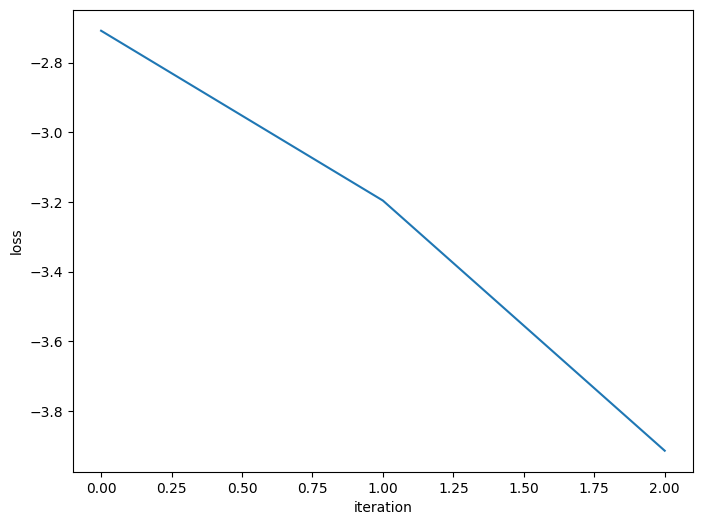

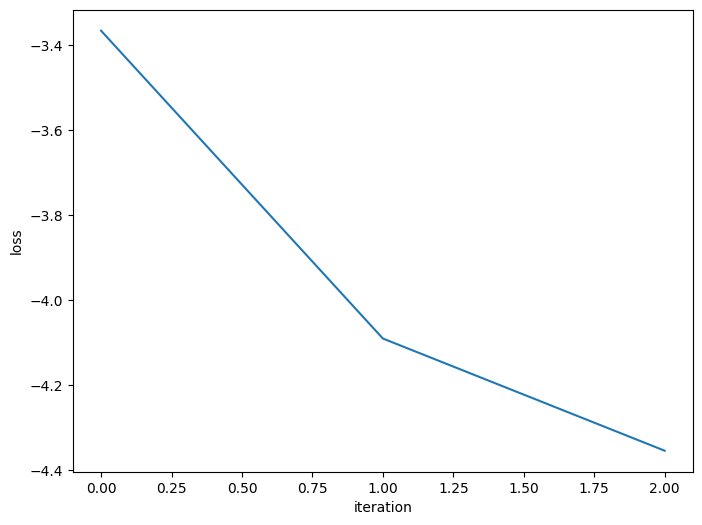

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -854.49865  validloss -779.70563±0.00000  bestvalidloss -779.70563  last_update 0
train: iter 1  trainloss -877.94794  validloss -752.58308±0.00000  bestvalidloss -779.70563  last_update 1
train: iter 2  trainloss -858.53049  validloss -795.56603±0.00000  bestvalidloss -795.56603  last_update 0
train: iter 3  trainloss -872.02754  validloss -739.19103±0.00000  bestvalidloss -795.56603  last_update 1
train: iter 4  trainloss -882.59377  validloss -777.57209±0.00000  bestvalidloss -795.56603  last_update 2
train: iter 5  trainloss -860.58025  validloss -738.24380±0.00000  bestvalidloss -795.56603  last_update 3
train: iter 6  trainloss -864.86337  validloss -763.59930±0.00000  bestvalidloss -795.56603  last_update 4
train: iter 7  trainloss -868.35541  validloss -778.56692±0.00000  bestvalidloss -795.56603  last_update 5
train: iter 8  trainloss -827.66165  validloss -670.38534±0.00000  bestvalidloss -795.56603  last_u

train: iter 76  trainloss -873.17168  validloss -793.04993±0.00000  bestvalidloss -798.92422  last_update 45
train: iter 77  trainloss -845.65372  validloss -780.37821±0.00000  bestvalidloss -798.92422  last_update 46
train: iter 78  trainloss -864.86228  validloss -782.34213±0.00000  bestvalidloss -798.92422  last_update 47
train: iter 79  trainloss -882.57366  validloss -797.98407±0.00000  bestvalidloss -798.92422  last_update 48
train: iter 80  trainloss -878.09623  validloss -764.49366±0.00000  bestvalidloss -798.92422  last_update 49
train: iter 81  trainloss -865.39421  validloss -677.10027±0.00000  bestvalidloss -798.92422  last_update 50
train: iter 82  trainloss -831.92957  validloss -785.59186±0.00000  bestvalidloss -798.92422  last_update 51
train: iter 83  trainloss -872.10084  validloss -758.50380±0.00000  bestvalidloss -798.92422  last_update 52
train: iter 84  trainloss -874.13749  validloss -765.57423±0.00000  bestvalidloss -798.92422  last_update 53
train: iter 85  tra

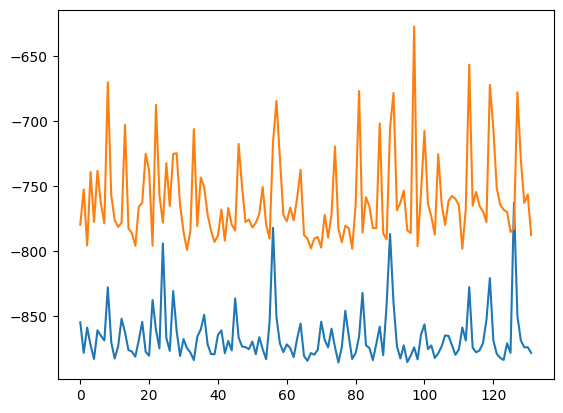

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-30 01:14:20.054444


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.36994  validloss 0.47687±0.00000  bestvalidloss 0.47687  last_update 0
train: iter 1  trainloss 0.34428  validloss 0.39770±0.00000  bestvalidloss 0.39770  last_update 0
train: iter 2  trainloss 0.33207  validloss 0.38296±0.00000  bestvalidloss 0.38296  last_update 0
train: iter 3  trainloss 0.32981  validloss 0.37953±0.00000  bestvalidloss 0.37953  last_update 0
train: iter 4  trainloss 0.32931  validloss 0.37045±0.00000  bestvalidloss 0.37045  last_update 0
train: iter 5  trainloss 0.32694  validloss 0.36867±0.00000  bestvalidloss 0.36867  last_update 0
train: iter 6  trainloss 0.32238  validloss 0.36019±0.00000  bestvalidloss 0.36019  last_update 0
train: iter 7  trainloss 0.32339  validloss 0.36509±0.00000  bestvalidloss 0.36019  last_update 1
train: iter 8  trainloss 0.32114  validloss 0.34877±0.00000  bestvalidloss 0.34877  last_update 0
train: iter 9  trainloss 0.32414  validloss 0.35531±0.00000  bestvalidloss 0.34877  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.30563  validloss 0.35160±0.00000  bestvalidloss 0.33517  last_update 38
train: iter 84  trainloss 0.30289  validloss 0.36895±0.00000  bestvalidloss 0.33517  last_update 39
train: iter 85  trainloss 0.30446  validloss 0.38208±0.00000  bestvalidloss 0.33517  last_update 40
train: iter 86  trainloss 0.30235  validloss 0.36068±0.00000  bestvalidloss 0.33517  last_update 41
train: iter 87  trainloss 0.30114  validloss 0.35120±0.00000  bestvalidloss 0.33517  last_update 42
train: iter 88  trainloss 0.29980  validloss 0.35237±0.00000  bestvalidloss 0.33517  last_update 43
train: iter 89  trainloss 0.30132  validloss 0.34395±0.00000  bestvalidloss 0.33517  last_update 44
train: iter 90  trainloss 0.29998  validloss 0.33988±0.00000  bestvalidloss 0.33517  last_update 45
train: iter 91  trainloss 0.29992  validloss 0.35388±0.00000  bestvalidloss 0.33517  last_update 46
train: iter 92  trainloss 0.30164  validloss 0.35394±0.00000  bestvalidloss 0.33517  last_update 47


train_loss:  -4.27280554253459
valid_loss:  -3.230211863684654
weight_alpha 1.0 h_min_tilde -11.827847 ell_tilde -4.064286806764603 kappa_tilde 0.00035889677095492787
train_loss:  -4.41724355854988
valid_loss:  -3.7421034448623667
weight_alpha 0.1 h_min_tilde -11.827847 ell_tilde -4.2822155358123775 kappa_tilde 0.0003640426093449908


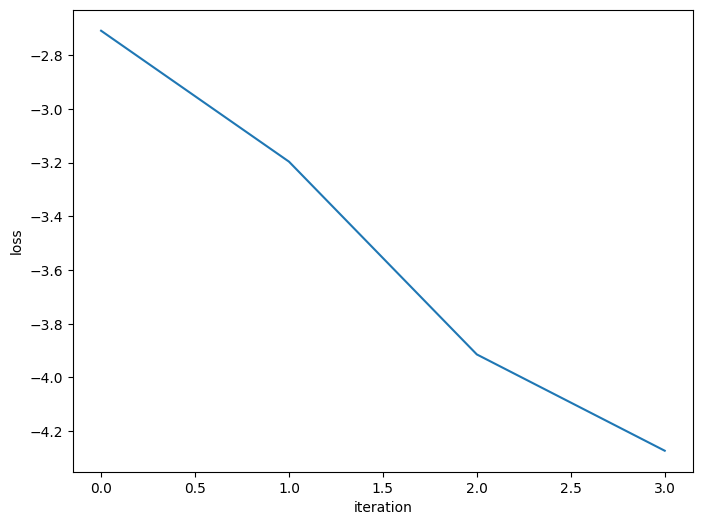

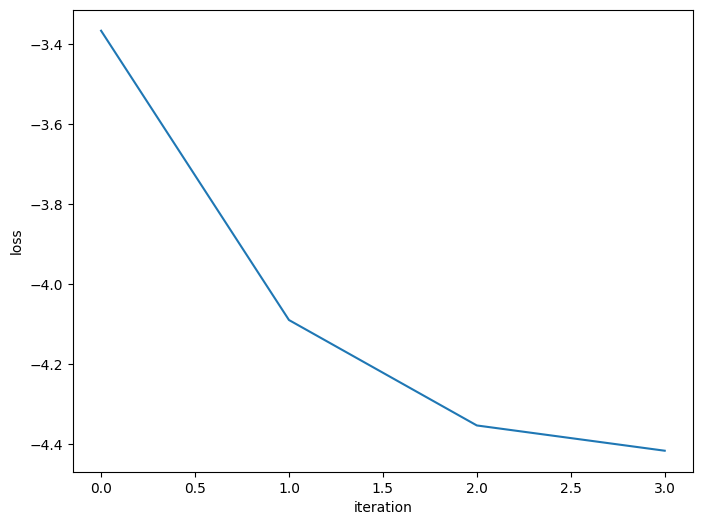

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -892.14766  validloss -754.90185±0.00000  bestvalidloss -754.90185  last_update 0
train: iter 1  trainloss -902.22290  validloss -791.25044±0.00000  bestvalidloss -791.25044  last_update 0
train: iter 2  trainloss -898.87883  validloss -722.93162±0.00000  bestvalidloss -791.25044  last_update 1
train: iter 3  trainloss -892.73974  validloss -639.04204±0.00000  bestvalidloss -791.25044  last_update 2
train: iter 4  trainloss -889.14771  validloss -771.86153±0.00000  bestvalidloss -791.25044  last_update 3
train: iter 5  trainloss -907.46989  validloss -789.65320±0.00000  bestvalidloss -791.25044  last_update 4
train: iter 6  trainloss -901.24220  validloss -756.32628±0.00000  bestvalidloss -791.25044  last_update 5
train: iter 7  trainloss -863.31338  validloss -708.51701±0.00000  bestvalidloss -791.25044  last_update 6
train: iter 8  trainloss -897.28399  validloss -792.44534±0.00000  bestvalidloss -792.44534  last_u

train: iter 76  trainloss -911.56144  validloss -821.07635±0.00000  bestvalidloss -821.07635  last_update 0
train: iter 77  trainloss -872.99992  validloss -800.40855±0.00000  bestvalidloss -821.07635  last_update 1
train: iter 78  trainloss -907.32630  validloss -773.83647±0.00000  bestvalidloss -821.07635  last_update 2
train: iter 79  trainloss -907.80645  validloss -748.90976±0.00000  bestvalidloss -821.07635  last_update 3
train: iter 80  trainloss -888.17993  validloss -788.42278±0.00000  bestvalidloss -821.07635  last_update 4
train: iter 81  trainloss -909.37438  validloss -761.22695±0.00000  bestvalidloss -821.07635  last_update 5
train: iter 82  trainloss -916.52035  validloss -781.45800±0.00000  bestvalidloss -821.07635  last_update 6
train: iter 83  trainloss -917.67281  validloss -784.95405±0.00000  bestvalidloss -821.07635  last_update 7
train: iter 84  trainloss -873.42175  validloss -414.23325±0.00000  bestvalidloss -821.07635  last_update 8
train: iter 85  trainloss -9

train: iter 151  trainloss -914.75747  validloss -762.26532±0.00000  bestvalidloss -821.11586  last_update 64
train: iter 152  trainloss -915.50968  validloss -690.07175±0.00000  bestvalidloss -821.11586  last_update 65
train: iter 153  trainloss -894.29255  validloss -721.02759±0.00000  bestvalidloss -821.11586  last_update 66
train: iter 154  trainloss -897.14223  validloss -765.46875±0.00000  bestvalidloss -821.11586  last_update 67
train: iter 155  trainloss -901.40135  validloss -527.91812±0.00000  bestvalidloss -821.11586  last_update 68
train: iter 156  trainloss -901.64519  validloss -762.06246±0.00000  bestvalidloss -821.11586  last_update 69
train: iter 157  trainloss -889.55165  validloss -769.48624±0.00000  bestvalidloss -821.11586  last_update 70
train: iter 158  trainloss -911.17396  validloss -767.07129±0.00000  bestvalidloss -821.11586  last_update 71
train: iter 159  trainloss -907.09755  validloss -788.06505±0.00000  bestvalidloss -821.11586  last_update 72
train: ite

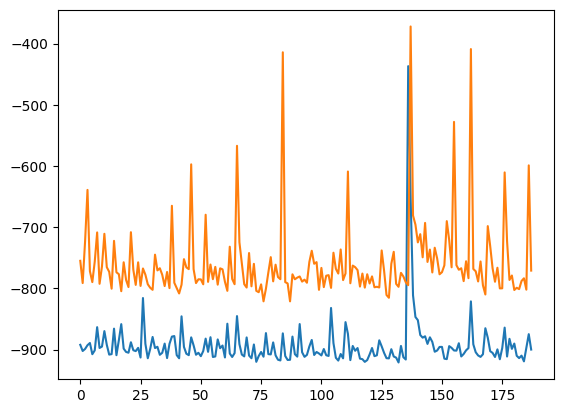

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-30 01:37:36.616049


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9
predict diverge [-19.44115334  -9.63840207  58.44292685  34.54832893] [-0.39320821  0.85457159  1.7377673   0.4815263 ] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 67

 10

 11

 12
predict diverge [-12.76531382 -15.79550091  40.90657187  35.58984161] [-0.68974708 -0.87889292  1.99111585  1.69118746] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 52
predict diverge [-16.03370082 -12.807551    47.91169069  35.32528286] [-0.5807122   0.15339119  1.91035966  0.9493521 ] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 60

 13

 14

 15
predict diverge [-12.52688404 -13.01589869  43.48104499  35.23108652] [-0.55983793 -0.36038083  1.84971839  0.86615183] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 51

 16

 17
predict 

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.34120  validloss 0.40669±0.00000  bestvalidloss 0.40669  last_update 0
train: iter 1  trainloss 0.33479  validloss 0.39145±0.00000  bestvalidloss 0.39145  last_update 0
train: iter 2  trainloss 0.33245  validloss 0.39099±0.00000  bestvalidloss 0.39099  last_update 0
train: iter 3  trainloss 0.33206  validloss 0.40683±0.00000  bestvalidloss 0.39099  last_update 1
train: iter 4  trainloss 0.33570  validloss 0.40467±0.00000  bestvalidloss 0.39099  last_update 2
train: iter 5  trainloss 0.32723  validloss 0.41160±0.00000  bestvalidloss 0.39099  last_update 3
train: iter 6  trainloss 0.32871  validloss 0.39718±0.00000  bestvalidloss 0.39099  last_update 4
train: iter 7  trainloss 0.32057  validloss 0.39840±0.00000  bestvalidloss 0.39099  last_update 5
train: iter 8  trainloss 0.32324  validloss 0.39887±0.00000  bestvalidloss 0.39099  last_update 6
train: iter 9  trainloss 0.32481  validloss 0.40773±0.00000  bestvalidloss 0.39099  last_update 7
train: iter 10  trai

train: iter 84  trainloss 0.30702  validloss 0.39928±0.00000  bestvalidloss 0.38463  last_update 30
train: iter 85  trainloss 0.31300  validloss 0.41321±0.00000  bestvalidloss 0.38463  last_update 31
train: iter 86  trainloss 0.30460  validloss 0.39200±0.00000  bestvalidloss 0.38463  last_update 32
train: iter 87  trainloss 0.30995  validloss 0.38807±0.00000  bestvalidloss 0.38463  last_update 33
train: iter 88  trainloss 0.30826  validloss 0.38587±0.00000  bestvalidloss 0.38463  last_update 34
train: iter 89  trainloss 0.30867  validloss 0.38615±0.00000  bestvalidloss 0.38463  last_update 35
train: iter 90  trainloss 0.30899  validloss 0.39262±0.00000  bestvalidloss 0.38463  last_update 36
train: iter 91  trainloss 0.30500  validloss 0.38822±0.00000  bestvalidloss 0.38463  last_update 37
train: iter 92  trainloss 0.30685  validloss 0.40384±0.00000  bestvalidloss 0.38463  last_update 38
train: iter 93  trainloss 0.30643  validloss 0.40382±0.00000  bestvalidloss 0.38463  last_update 39


train: iter 166  trainloss 0.29830  validloss 0.37964±0.00000  bestvalidloss 0.37241  last_update 39
train: iter 167  trainloss 0.29989  validloss 0.39368±0.00000  bestvalidloss 0.37241  last_update 40
train: iter 168  trainloss 0.29957  validloss 0.38186±0.00000  bestvalidloss 0.37241  last_update 41
train: iter 169  trainloss 0.29749  validloss 0.38692±0.00000  bestvalidloss 0.37241  last_update 42
train: iter 170  trainloss 0.29637  validloss 0.38525±0.00000  bestvalidloss 0.37241  last_update 43
train: iter 171  trainloss 0.30031  validloss 0.39080±0.00000  bestvalidloss 0.37241  last_update 44
train: iter 172  trainloss 0.30033  validloss 0.39298±0.00000  bestvalidloss 0.37241  last_update 45
train: iter 173  trainloss 0.29841  validloss 0.39680±0.00000  bestvalidloss 0.37241  last_update 46
train: iter 174  trainloss 0.29900  validloss 0.37289±0.00000  bestvalidloss 0.37241  last_update 47
train: iter 175  trainloss 0.29569  validloss 0.39615±0.00000  bestvalidloss 0.37241  last_

train: iter 248  trainloss 0.29151  validloss 0.39728±0.00000  bestvalidloss 0.36970  last_update 23
train: iter 249  trainloss 0.28993  validloss 0.39841±0.00000  bestvalidloss 0.36970  last_update 24
train: iter 250  trainloss 0.29069  validloss 0.39173±0.00000  bestvalidloss 0.36970  last_update 25
train: iter 251  trainloss 0.29006  validloss 0.40319±0.00000  bestvalidloss 0.36970  last_update 26
train: iter 252  trainloss 0.29287  validloss 0.38983±0.00000  bestvalidloss 0.36970  last_update 27
train: iter 253  trainloss 0.29126  validloss 0.40469±0.00000  bestvalidloss 0.36970  last_update 28
train: iter 254  trainloss 0.29462  validloss 0.39152±0.00000  bestvalidloss 0.36970  last_update 29
train: iter 255  trainloss 0.28951  validloss 0.38552±0.00000  bestvalidloss 0.36970  last_update 30
train: iter 256  trainloss 0.29233  validloss 0.39353±0.00000  bestvalidloss 0.36970  last_update 31
train: iter 257  trainloss 0.29164  validloss 0.39703±0.00000  bestvalidloss 0.36970  last_

train_loss:  -3.48780382643938
valid_loss:  -3.3931033714056014
weight_alpha 1.0 h_min_tilde -11.709837 ell_tilde -3.4688637354326244 kappa_tilde 0.000348345936226077
train_loss:  -4.290382639312743
valid_loss:  -3.788680118560791
weight_alpha 0.1 h_min_tilde -11.709837 ell_tilde -4.1900421351623525 kappa_tilde 0.00036466745356342737


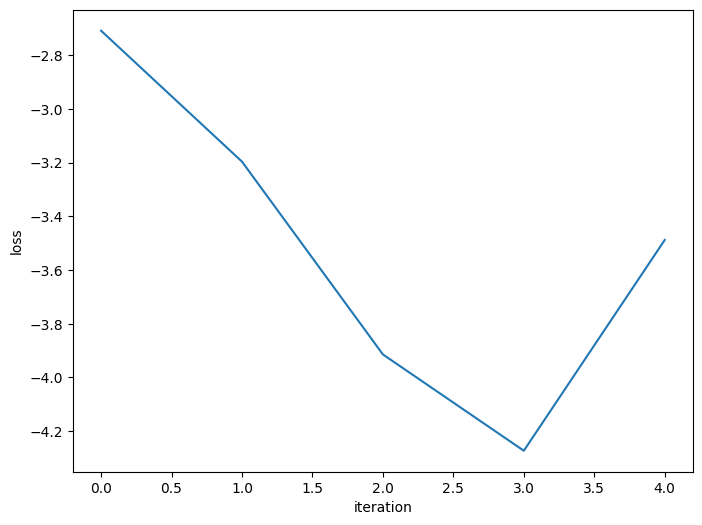

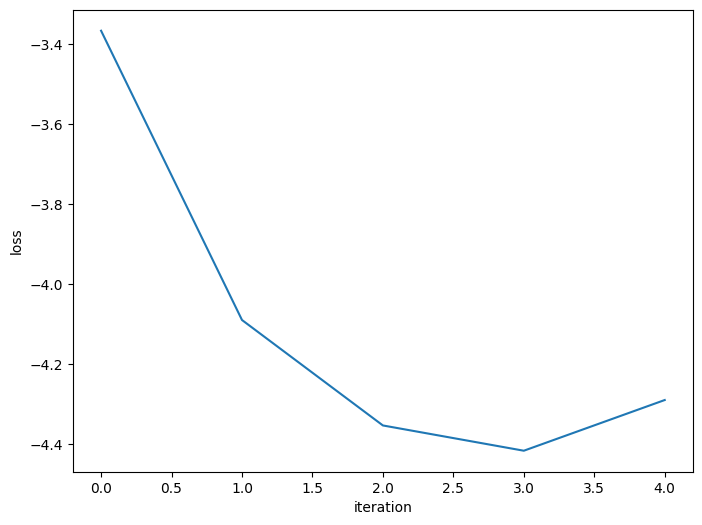

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -847.02750  validloss -758.85152±0.00000  bestvalidloss -758.85152  last_update 0
train: iter 1  trainloss -852.60136  validloss -746.45835±0.00000  bestvalidloss -758.85152  last_update 1
train: iter 2  trainloss -811.04299  validloss -654.72644±0.00000  bestvalidloss -758.85152  last_update 2
train: iter 3  trainloss -855.95008  validloss -724.43521±0.00000  bestvalidloss -758.85152  last_update 3
train: iter 4  trainloss -839.93115  validloss -747.52044±0.00000  bestvalidloss -758.85152  last_update 4
train: iter 5  trainloss -814.74448  validloss -527.81949±0.00000  bestvalidloss -758.85152  last_update 5
train: iter 6  trainloss -856.12060  validloss -730.44210±0.00000  bestvalidloss -758.85152  last_update 6
train: iter 7  trainloss -861.24591  validloss -725.63002±0.00000  bestvalidloss -758.85152  last_update 7
train: iter 8  trainloss -804.13202  validloss -759.82760±0.00000  bestvalidloss -759.82760  last_u

train: iter 76  trainloss -863.80275  validloss -718.12292±0.00000  bestvalidloss -783.08729  last_update 50
train: iter 77  trainloss -855.32333  validloss -766.41942±0.00000  bestvalidloss -783.08729  last_update 51
train: iter 78  trainloss -855.92195  validloss -779.87817±0.00000  bestvalidloss -783.08729  last_update 52
train: iter 79  trainloss -721.11811  validloss -763.30135±0.00000  bestvalidloss -783.08729  last_update 53
train: iter 80  trainloss -577.68087  validloss -688.85486±0.00000  bestvalidloss -783.08729  last_update 54
train: iter 81  trainloss -767.10652  validloss -603.78053±0.00000  bestvalidloss -783.08729  last_update 55
train: iter 82  trainloss -808.06582  validloss -664.19957±0.00000  bestvalidloss -783.08729  last_update 56
train: iter 83  trainloss -828.79587  validloss -698.22120±0.00000  bestvalidloss -783.08729  last_update 57
train: iter 84  trainloss -838.65416  validloss -689.95654±0.00000  bestvalidloss -783.08729  last_update 58
train: iter 85  tra

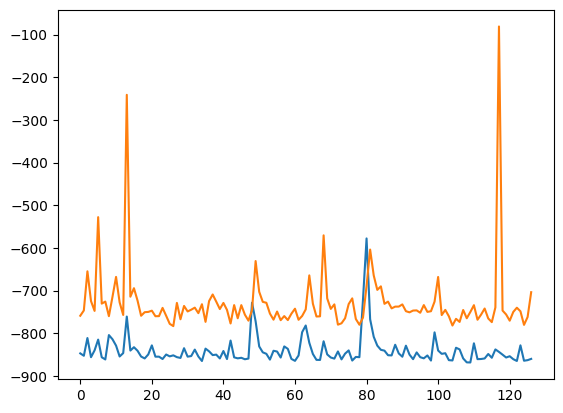

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-30 02:00:42.375818


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
predict diverge [-20.59995189  -2.75694907  47.94174131  36.89529753] [-0.26795046  0.19437988  1.20399552  7.00051391] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 74
predict diverge [-22.19208933 -10.36700623  45.16616101  34.74279757] [-0.59718296  0.20035026  1.75867455  1.4447652 ] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 71

 1
predict diverge [-10.60313293 -12.75645973  34.88302629  35.68603532] [-0.65876865 -0.40928603  1.8852295   1.83533801] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 42

 2

 3

 4
predict diverge [-19.40235027  -5.65737475  51.23783507  37.16721594] [-0.39861579 -0.161142    1.52357478  2.81481926] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 67

 5
predict diverge [-19.28974776  -5.25548805  40.24900386  35.2874


 51
predict diverge [-14.40630701 -13.2919565   37.54561331  35.47917459] [-0.74909974 -0.24791162  1.8234213   1.62717676] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 50

 52

 53

 54

 55

 56

 57

 58
predict diverge [-18.22797444  -6.48864541  47.2611022   37.29075783] [-0.44600538  0.58166767  1.43622884  6.40272048] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 59

 59

 60

 61
predict diverge [-13.91049067 -12.95546663  35.248471    35.28085626] [-0.69821242 -0.53050296  1.84424857  1.96528637] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 75
predict diverge [-17.52251542 -12.31437487  38.95139695  36.1456361 ] [-0.70393319 -0.27934536  1.79774569  1.85009928] [118.327385  18.965528 208.82301   34.419247] [ 59.163692   9.482764 104.41151   17.209623] sim_timestep 78

 62

 63
predict diverge [ 3.551

In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.31479  validloss 0.38144±0.00000  bestvalidloss 0.38144  last_update 0
train: iter 1  trainloss 0.30366  validloss 0.37229±0.00000  bestvalidloss 0.37229  last_update 0
train: iter 2  trainloss 0.29884  validloss 0.37268±0.00000  bestvalidloss 0.37229  last_update 1
train: iter 3  trainloss 0.29931  validloss 0.35343±0.00000  bestvalidloss 0.35343  last_update 0
train: iter 4  trainloss 0.29137  validloss 0.35066±0.00000  bestvalidloss 0.35066  last_update 0
train: iter 5  trainloss 0.29481  validloss 0.35496±0.00000  bestvalidloss 0.35066  last_update 1
train: iter 6  trainloss 0.29272  validloss 0.35888±0.00000  bestvalidloss 0.35066  last_update 2
train: iter 7  trainloss 0.29099  validloss 0.36029±0.00000  bestvalidloss 0.35066  last_update 3
train: iter 8  trainloss 0.28926  validloss 0.34921±0.00000  bestvalidloss 0.34921  last_update 0
train: iter 9  trainloss 0.28983  validloss 0.35495±0.00000  bestvalidloss 0.34921  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.27223  validloss 0.34530±0.00000  bestvalidloss 0.33098  last_update 10
train: iter 84  trainloss 0.27152  validloss 0.33493±0.00000  bestvalidloss 0.33098  last_update 11
train: iter 85  trainloss 0.26694  validloss 0.33654±0.00000  bestvalidloss 0.33098  last_update 12
train: iter 86  trainloss 0.27113  validloss 0.33580±0.00000  bestvalidloss 0.33098  last_update 13
train: iter 87  trainloss 0.26964  validloss 0.34239±0.00000  bestvalidloss 0.33098  last_update 14
train: iter 88  trainloss 0.26761  validloss 0.32976±0.00000  bestvalidloss 0.32976  last_update 0
train: iter 89  trainloss 0.26867  validloss 0.34213±0.00000  bestvalidloss 0.32976  last_update 1
train: iter 90  trainloss 0.26778  validloss 0.33029±0.00000  bestvalidloss 0.32976  last_update 2
train: iter 91  trainloss 0.26952  validloss 0.33653±0.00000  bestvalidloss 0.32976  last_update 3
train: iter 92  trainloss 0.26970  validloss 0.33964±0.00000  bestvalidloss 0.32976  last_update 4
train

train: iter 165  trainloss 0.26124  validloss 0.33492±0.00000  bestvalidloss 0.32511  last_update 23
train: iter 166  trainloss 0.26085  validloss 0.33348±0.00000  bestvalidloss 0.32511  last_update 24
train: iter 167  trainloss 0.25753  validloss 0.33150±0.00000  bestvalidloss 0.32511  last_update 25
train: iter 168  trainloss 0.26137  validloss 0.33166±0.00000  bestvalidloss 0.32511  last_update 26
train: iter 169  trainloss 0.25849  validloss 0.32768±0.00000  bestvalidloss 0.32511  last_update 27
train: iter 170  trainloss 0.26043  validloss 0.33207±0.00000  bestvalidloss 0.32511  last_update 28
train: iter 171  trainloss 0.25962  validloss 0.34237±0.00000  bestvalidloss 0.32511  last_update 29
train: iter 172  trainloss 0.25982  validloss 0.33052±0.00000  bestvalidloss 0.32511  last_update 30
train: iter 173  trainloss 0.25864  validloss 0.33045±0.00000  bestvalidloss 0.32511  last_update 31
train: iter 174  trainloss 0.26347  validloss 0.33218±0.00000  bestvalidloss 0.32511  last_

([0.3147897390648723,
  0.30366256991401314,
  0.29884174577891826,
  0.2993070130236447,
  0.29136525839567184,
  0.29481308525428174,
  0.2927186408080161,
  0.29098523380234836,
  0.28925830498337746,
  0.28983317138627174,
  0.28848400032147764,
  0.28569881822913884,
  0.28817092422395946,
  0.28679910777136686,
  0.286146701592952,
  0.28714569555595515,
  0.28089445251971484,
  0.2849825367331505,
  0.28719512643292544,
  0.28543662689626215,
  0.28356171818450093,
  0.2820417838171124,
  0.2835632669739425,
  0.2868142543360591,
  0.28528313506394626,
  0.2809119968675077,
  0.28136671697720883,
  0.27875426039099693,
  0.27984814113005996,
  0.28150009056553243,
  0.27998003363609314,
  0.2805680473335087,
  0.2849424027837813,
  0.2856858386658132,
  0.27932139551267027,
  0.2815924006514251,
  0.28031013421714307,
  0.2791289404965937,
  0.2797325195744634,
  0.2775326084345579,
  0.2764650323428214,
  0.27640300448983907,
  0.2794384482316673,
  0.28048727484419944,
  0.276

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -2.7382249379992483
valid_loss:  -2.54634846252203
weight_alpha 1.0 h_min_tilde -12.011391 ell_tilde -2.6998496429038044 kappa_tilde 0.0003277096416305649
train_loss:  -3.825756851959228
valid_loss:  -3.3659893292903904
weight_alpha 0.1 h_min_tilde -12.011391 ell_tilde -3.733803347425461 kappa_tilde 0.0003475746660053342


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 118.70639  validloss 133.68751±0.00000  bestvalidloss 133.68751  last_update 0
train: iter 1  trainloss 92.34005  validloss 101.88036±0.00000  bestvalidloss 101.88036  last_update 0
train: iter 2  trainloss 71.11612  validloss 77.75492±0.00000  bestvalidloss 77.75492  last_update 0
train: iter 3  trainloss 56.17781  validloss 61.78993±0.00000  bestvalidloss 61.78993  last_update 0
train: iter 4  trainloss 43.75282  validloss 46.35259±0.00000  bestvalidloss 46.35259  last_update 0
train: iter 5  trainloss 34.17184  validloss 36.45655±0.00000  bestvalidloss 36.45655  last_update 0
train: iter 6  trainloss 27.34209  validloss 29.48828±0.00000  bestvalidloss 29.48828  last_update 0
train: iter 7  trainloss 20.98258  validloss 22.35908±0.00000  bestvalidloss 22.35908  last_update 0
train: iter 8  trainloss 16.67494  validloss 16.39872±0.00000  bestvalidloss 16.39872  last_update 0
train: iter 9  trainloss 12.61028  validloss 12.42398±0.00000  bestvalidloss 12.42398 

train: iter 96  trainloss -1.02174  validloss -1.71031±0.00000  bestvalidloss -1.86935  last_update 61
train: iter 97  trainloss -1.04594  validloss -1.70348±0.00000  bestvalidloss -1.86935  last_update 62
train: iter 98  trainloss -1.01751  validloss -1.69132±0.00000  bestvalidloss -1.86935  last_update 63
train: iter 99  trainloss -1.01391  validloss -1.69363±0.00000  bestvalidloss -1.86935  last_update 64
train: iter 100  trainloss -1.08396  validloss -1.71935±0.00000  bestvalidloss -1.86935  last_update 65
train: iter 101  trainloss -1.01626  validloss -1.66738±0.00000  bestvalidloss -1.86935  last_update 66
train: iter 102  trainloss -1.03070  validloss -1.73270±0.00000  bestvalidloss -1.86935  last_update 67
train: iter 103  trainloss -1.02211  validloss -1.69939±0.00000  bestvalidloss -1.86935  last_update 68
train: iter 104  trainloss -1.03944  validloss -1.67045±0.00000  bestvalidloss -1.86935  last_update 69
train: iter 105  trainloss -1.02719  validloss -1.75118±0.00000  bes

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.9054, -1.1369, -5.1345, -3.7020], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 4.47160  validloss 12.12665±0.00000  bestvalidloss 12.12665  last_update 0
train: iter 1  trainloss 4.42386  validloss 13.21896±0.00000  bestvalidloss 12.12665  last_update 1
train: iter 2  trainloss 4.54098  validloss 12.35576±0.00000  bestvalidloss 12.12665  last_update 2
train: iter 3  trainloss 4.51557  validloss 12.99207±0.00000  bestvalidloss 12.12665  last_update 3
train: iter 4  trainloss 4.37149  validloss 13.25053±0.00000  bestvalidloss 12.12665  last_update 4
train: iter 5  trainloss 4.39685  validloss 12.57033±0.00000  bestvalidloss 12.12665  last_update 5
train: iter 6  trainloss 4.44591  validloss 12.83161±0.00000  bestvalidloss 12.12665  last_update 6
train: iter 7  trainloss 4.43147  validloss 12.32929±0.00000  bestvalidloss 12.12665  last_update 7
train: iter 8  trainloss 4.41907  validloss 12.69904±0.00000  bestvalidloss 12.12665  last_update 8
train: iter 9  trainloss 4.44341  validloss 13.22871±0.00000  bestvalidloss 12.12665  last_update 9


train: iter 82  trainloss 4.29083  validloss 12.59101±0.00000  bestvalidloss 11.20108  last_update 56
train: iter 83  trainloss 4.30056  validloss 12.78523±0.00000  bestvalidloss 11.20108  last_update 57
train: iter 84  trainloss 4.25189  validloss 13.60808±0.00000  bestvalidloss 11.20108  last_update 58
train: iter 85  trainloss 4.26145  validloss 12.60973±0.00000  bestvalidloss 11.20108  last_update 59
train: iter 86  trainloss 4.27524  validloss 12.82310±0.00000  bestvalidloss 11.20108  last_update 60
train: iter 87  trainloss 4.37507  validloss 13.17730±0.00000  bestvalidloss 11.20108  last_update 61
train: iter 88  trainloss 4.28233  validloss 13.24049±0.00000  bestvalidloss 11.20108  last_update 62
train: iter 89  trainloss 4.23724  validloss 13.61613±0.00000  bestvalidloss 11.20108  last_update 63
train: iter 90  trainloss 4.37773  validloss 12.49347±0.00000  bestvalidloss 11.20108  last_update 64
train: iter 91  trainloss 4.39881  validloss 12.90252±0.00000  bestvalidloss 11.20

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-11.8788)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(12.7007)


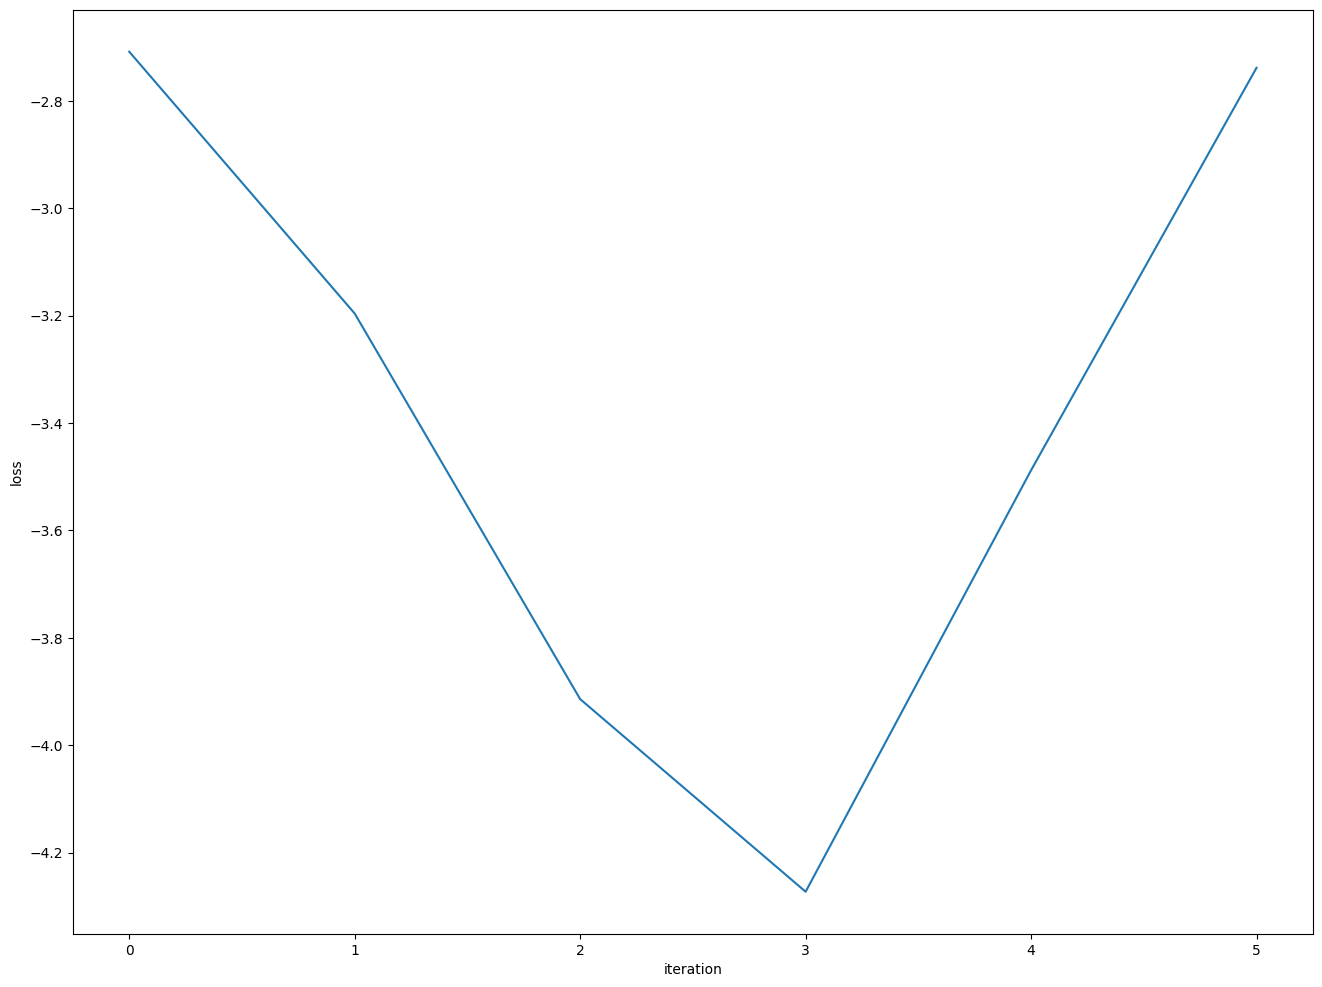

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

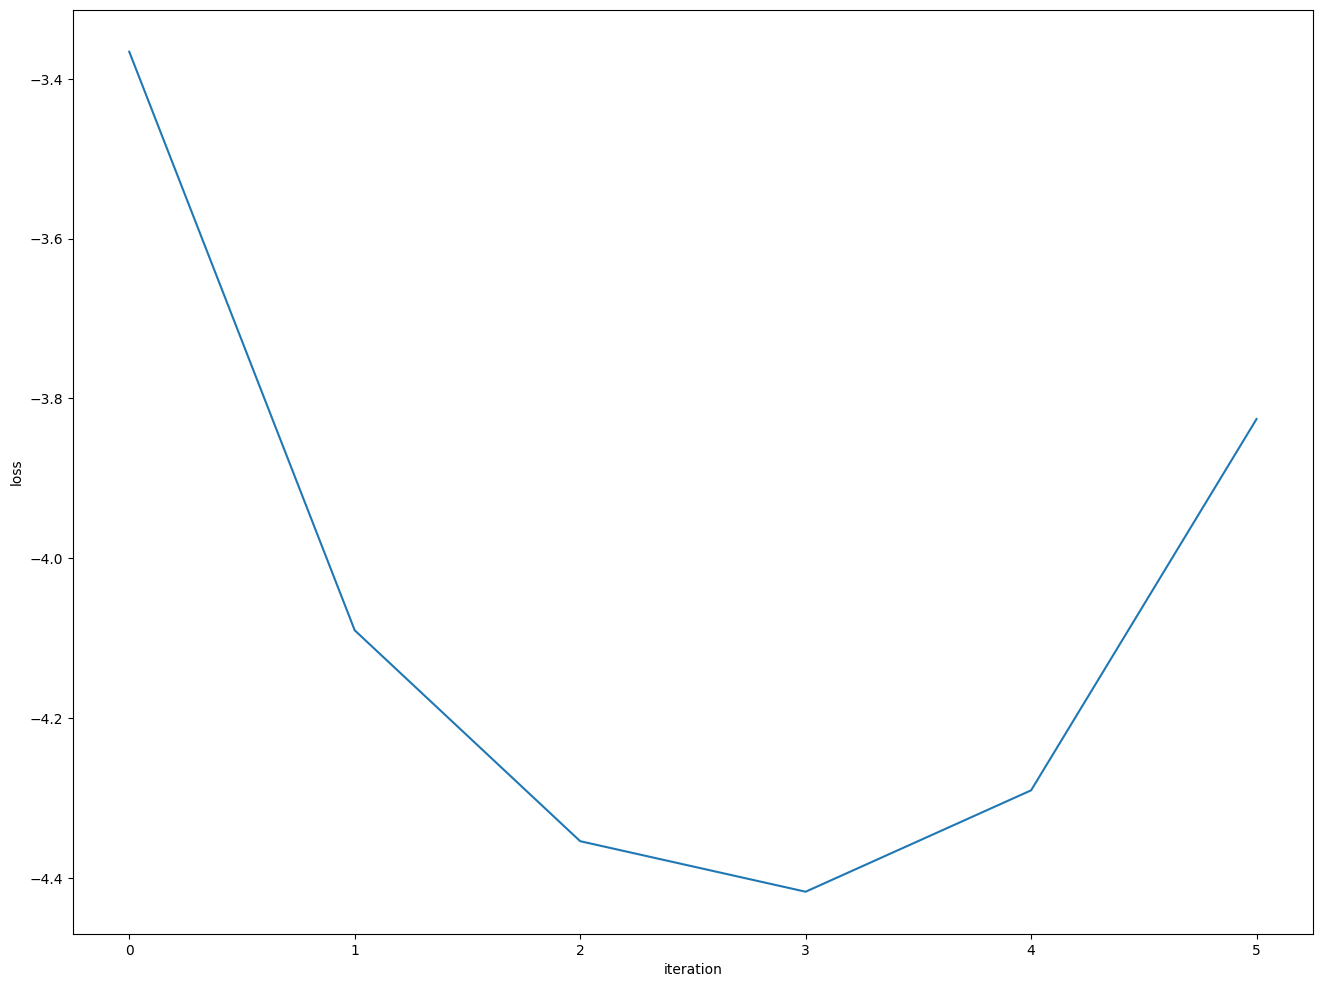

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")